# 0.0 Imports

In [2]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb
import optuna
import json
import requests
import pickle
from imblearn.combine        import SMOTETomek
from IPython.core.display    import HTML
from sklearn.metrics         import f1_score
from scipy                   import stats     as ss
from sklearn                 import ensemble  as en
from sklearn                 import neighbors as nh
from sklearn                 import linear_model as lm
from sklearn                 import metrics as mt
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import accuracy_score
from sklearn                 import preprocessing as pp
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from scikitplot.metrics      import plot_cumulative_gain, plot_lift_curve, plot_ks_statistic, plot_calibration_curve, plot_confusion_matrix 

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1) / (n - 1))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (k - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

def precision_at_k(data, k):
    
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(data, k):

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k,'recall_at_k']

def ranking_performance(model_name, x_validation, y_validation, yhat, yhat_b,top_k):

    data = x_validation.copy()
    data['response'] = y_validation.copy()

    # Propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score',ascending=False)

    acc = accuracy_score(y_validation, yhat_b)
    
    f1 = f1_score(y_validation, yhat_b)
    
    return pd.DataFrame(
        {'Model Name': model_name,
        'Precision at K': precision_at_k(data,k=top_k),
        'Recall at K': recall_at_k(data,k=top_k),
        'Accuracy': acc,
        'F1_score': f1},
        index=[0]
    )

def cross_validation(model_name, model, x_train, y_train, k, verbose=False):
    '''Função para realizar o Cross Validation dos modelos de Machine Learning'''
    precision_k_list = []
    recall_k_list    = []
    
    kfolds = StratifiedKFold(n_splits = 5, shuffle=True, random_state=5)
    
    for cv_train, cv_val in kfolds.split(x_train, y_train):
        
        # Cross-Validation Train
        xtrain_val = x_train.iloc[cv_train]
        ytrain_val = y_train.iloc[cv_train]
        
        # Cross-Validation Validation
        xval = x_train.iloc[cv_val]
        yval = y_train.iloc[cv_val]
        
        # Treinamento do modelo
        model.fit(xtrain_val, ytrain_val)

        # Previsão
        yhat_prob  = model.predict_proba(xval)
        yhat       = model.predict(xval)
        
        # Preparando os Dados
        data = xval.copy()
        data['response'] = yval.copy()

        # Score
        data['score'] = yhat_prob[:, 1].tolist()

        data = data.sort_values('score', ascending = False)

        # Performance
        precision_k = precision_at_k(data, k)
        precision_k_list.append(precision_k)

        recall_k = recall_at_k(data, k)
        recall_k_list.append(recall_k)
        
        acc = accuracy_score(yval, yhat)

        f1 = f1_score(yval, yhat)
                
    return pd.DataFrame({'Precision @k - CV': np.round(np.mean(precision_k_list), 3),
                         'Recall @k - CV': np.round(np.mean(recall_k_list), 3),
                         'Accuracy - CV': np.round(np.mean(acc), 3),
                         'F1_score - CV': np.round(np.mean(f1), 3)}, index=[model_name])
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
# Loading data

df_raw = pd.read_csv('../data/train.csv')

In [5]:
df_raw.head()

,id,gender,age,region_code,sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_insured,annual_premium,days_client_associate,interested
0,274711,Male,22,40,152,1,< 1 Year,Yes,0,25455.0,203,0
1,216540,Female,26,8,26,1,< 1 Year,No,1,38393.0,45,0
2,78984,Female,32,28,122,1,< 1 Year,Yes,0,32118.0,35,1
3,218369,Male,32,37,152,1,< 1 Year,Yes,0,37711.0,215,0
4,307216,Female,24,28,156,1,< 1 Year,Yes,0,48706.0,222,0


# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [7]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 304887
Número de colunas: 12


## 1.2 Data Types

In [8]:
df1.dtypes

id                         int64
gender                    object
age                        int64
region_code                int64
sales_channel              int64
driving_license            int64
vehicle_age               object
vehicle_damage            object
vehicle_insured            int64
annual_premium           float64
days_client_associate      int64
interested                 int64
dtype: object

## 1.3 Check NA

In [9]:
df1.isna().sum()

id                       0
gender                   0
age                      0
region_code              0
sales_channel            0
driving_license          0
vehicle_age              0
vehicle_damage           0
vehicle_insured          0
annual_premium           0
days_client_associate    0
interested               0
dtype: int64

## 1.4 Fill NA

- Não há dados NA no dataset

## 1.5 Change Types

- Não há dados para mudar no dataset

## 1.6 Descriptive Statistical

In [10]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [11]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, max, min, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190738.657112,190886.0,110004.186837,-0.001457,-1.199436
1,age,20.0,85.0,65.0,38.826897,36.0,15.515274,0.671710,-0.568526
2,region_code,0.0,52.0,52.0,26.396239,28.0,13.228728,-0.115538,-0.866961
3,sales_channel,1.0,163.0,162.0,112.053859,134.0,54.189199,-0.900677,-0.969360
4,driving_license,0.0,1.0,1.0,0.997855,1.0,0.046265,-21.521960,461.197806
5,vehicle_insured,0.0,1.0,1.0,0.458127,0.0,0.498244,0.168083,-1.971761
6,annual_premium,2630.0,540165.0,537535.0,30591.308311,31697.0,17239.257418,1.721299,32.191697
7,days_client_associate,10.0,299.0,289.0,154.392214,154.0,83.670175,0.002134,-1.200642
8,interested,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301907,3.298797


<AxesSubplot:xlabel='days_client_associate'>

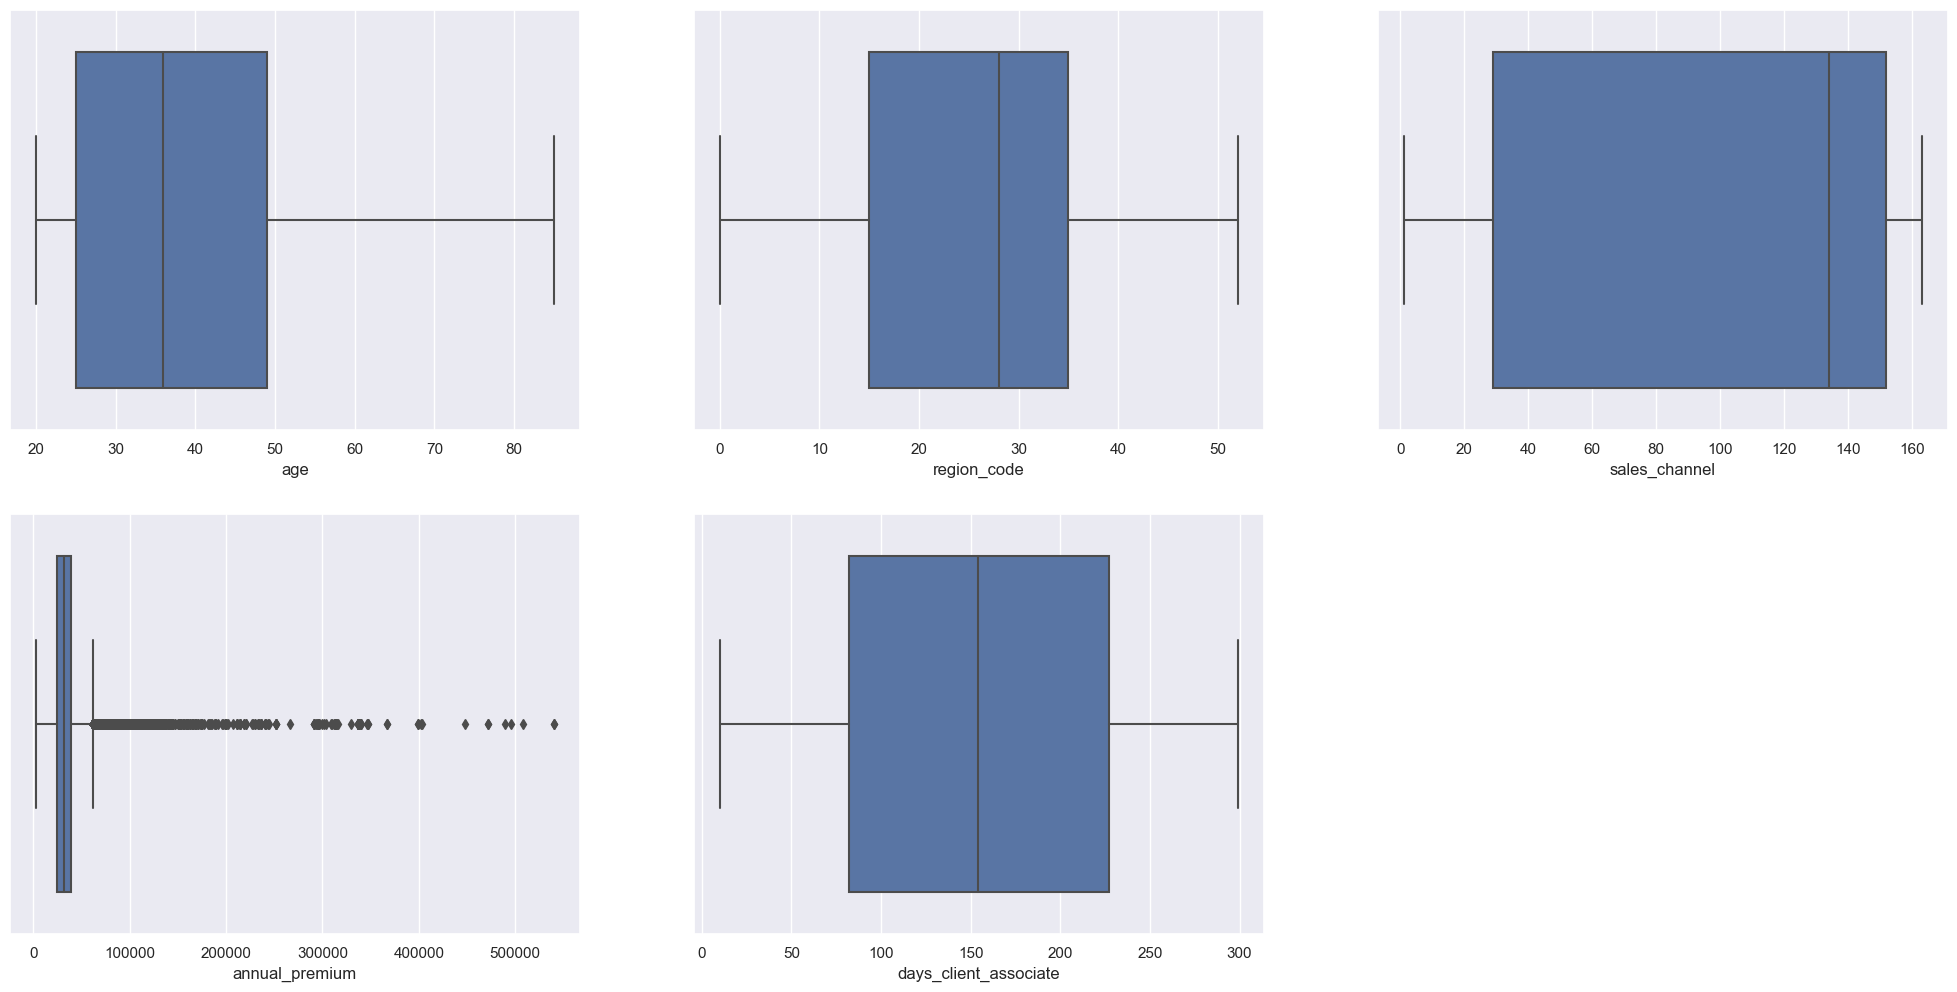

In [12]:
# Análise das variáveis numéricas no boxplot
plt.subplot(2, 3, 1)
sns.boxplot(x='age', data=num_attributes)

plt.subplot(2, 3, 2)
sns.boxplot(x='region_code', data=num_attributes)

plt.subplot(2, 3, 3)
sns.boxplot(x='sales_channel', data=num_attributes)

plt.subplot(2, 3, 4)
sns.boxplot(x='annual_premium', data=num_attributes)

plt.subplot(2, 3, 5)
sns.boxplot(x='days_client_associate', data=num_attributes)

# 2.0 Feature Engineering

In [13]:
df2 = df1.copy()

In [14]:
# vericle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                     'between_1_2_year' if x == '1-2 Year' else 
                                                     'over_2_years')

df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 Data Filtering

In [15]:
df3 = df2.copy()

# 4.0 EDA

In [16]:
df4 = df3.copy()

## 4.1 Análise Univariada

/Users/luishmq/.pyenv/versions/3.8.13/envs/insurance_cross_sell/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='interested', ylabel='Density'>

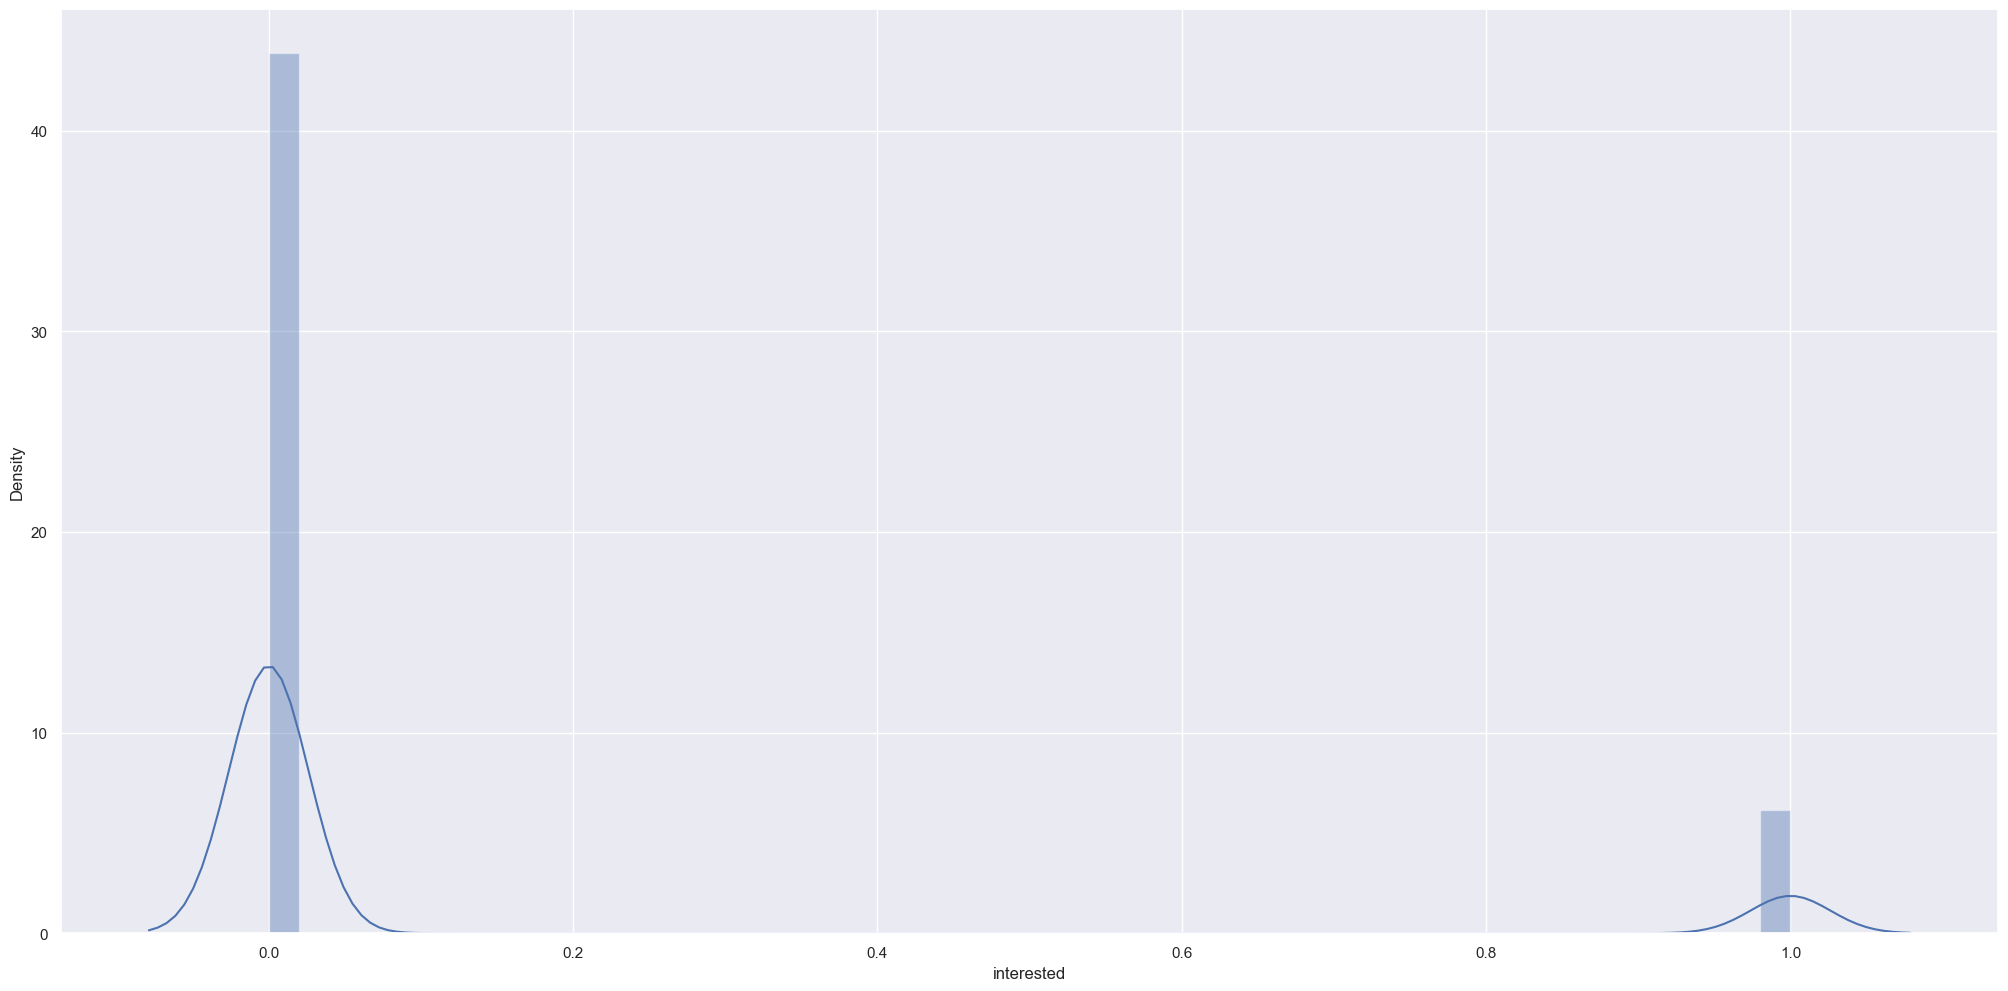

In [17]:
# Interested Variable

sns.distplot( df4['interested'] )

### 4.1.2 Numerical Variable

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'region_code'}>],
       [<AxesSubplot:title={'center':'sales_channel'}>,
        <AxesSubplot:title={'center':'driving_license'}>,
        <AxesSubplot:title={'center':'vehicle_insured'}>],
       [<AxesSubplot:title={'center':'annual_premium'}>,
        <AxesSubplot:title={'center':'days_client_associate'}>,
        <AxesSubplot:title={'center':'interested'}>]], dtype=object)

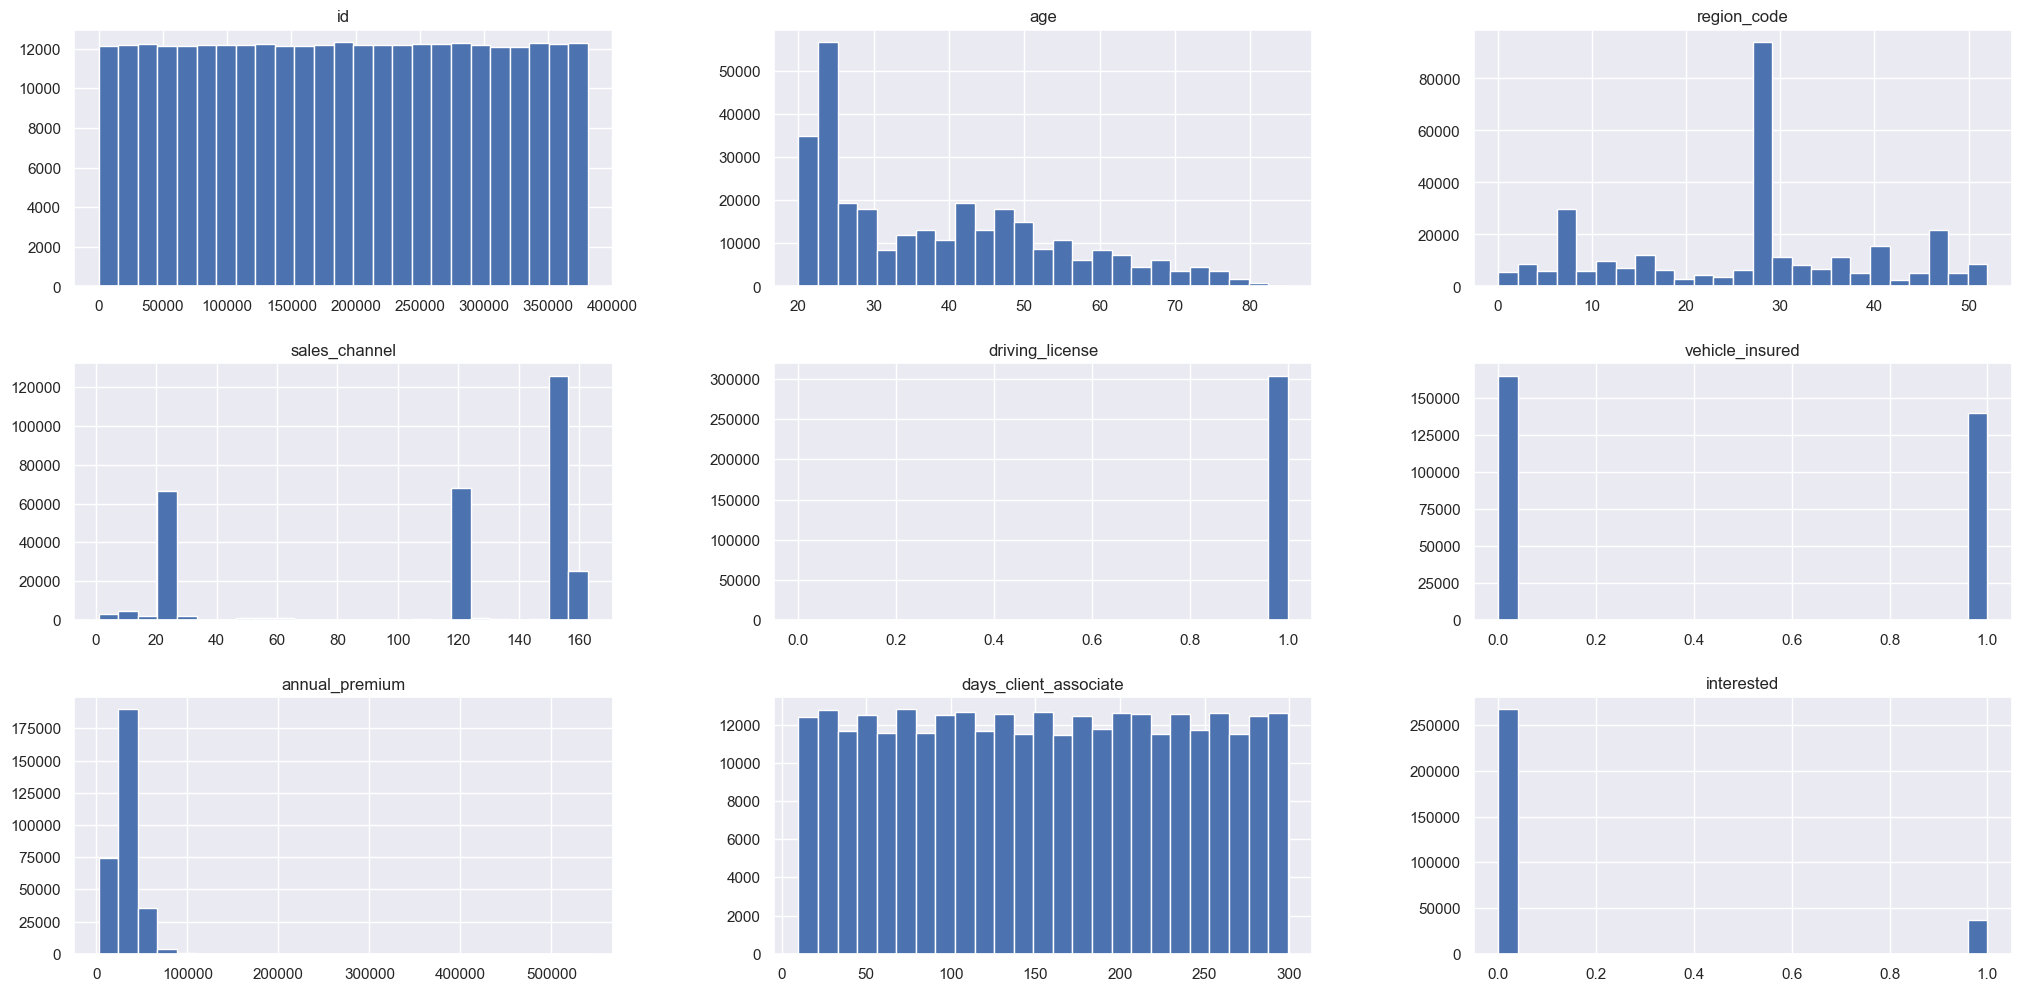

In [18]:
# Atributos numéricos 

num_attributes.hist(bins=25)

### 4.1.3 Categorical Variable

/Users/luishmq/.pyenv/versions/3.8.13/envs/insurance_cross_sell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


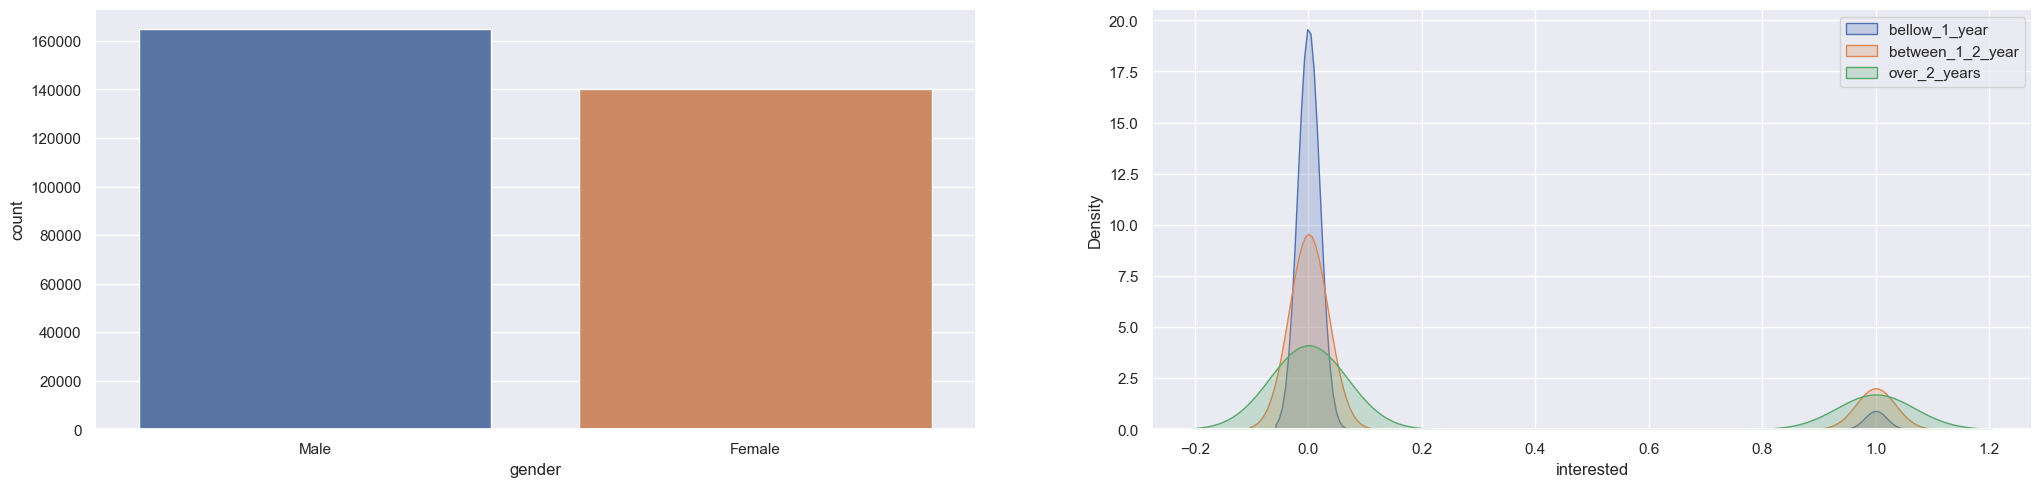

In [19]:
# geography
plt.subplot( 2, 2, 1 )
sns.countplot( df4['gender'] )

plt.subplot( 2, 2, 2 )
sns.kdeplot( df4[df4['vehicle_age'] == 'bellow_1_year']['interested'], label='bellow_1_year', shade=True )
sns.kdeplot( df4[df4['vehicle_age'] == 'between_1_2_year']['interested'], label='between_1_2_year', shade=True )
sns.kdeplot( df4[df4['vehicle_age'] == 'over_2_years']['interested'], label='over_2_years', shade=True )

plt.legend()

## 4.2 Análise Bivariada

### 4.2.1 Age

- Pessoas mais velhas tendem a ser mais interessadas em adquirir um seguro de automóvel.

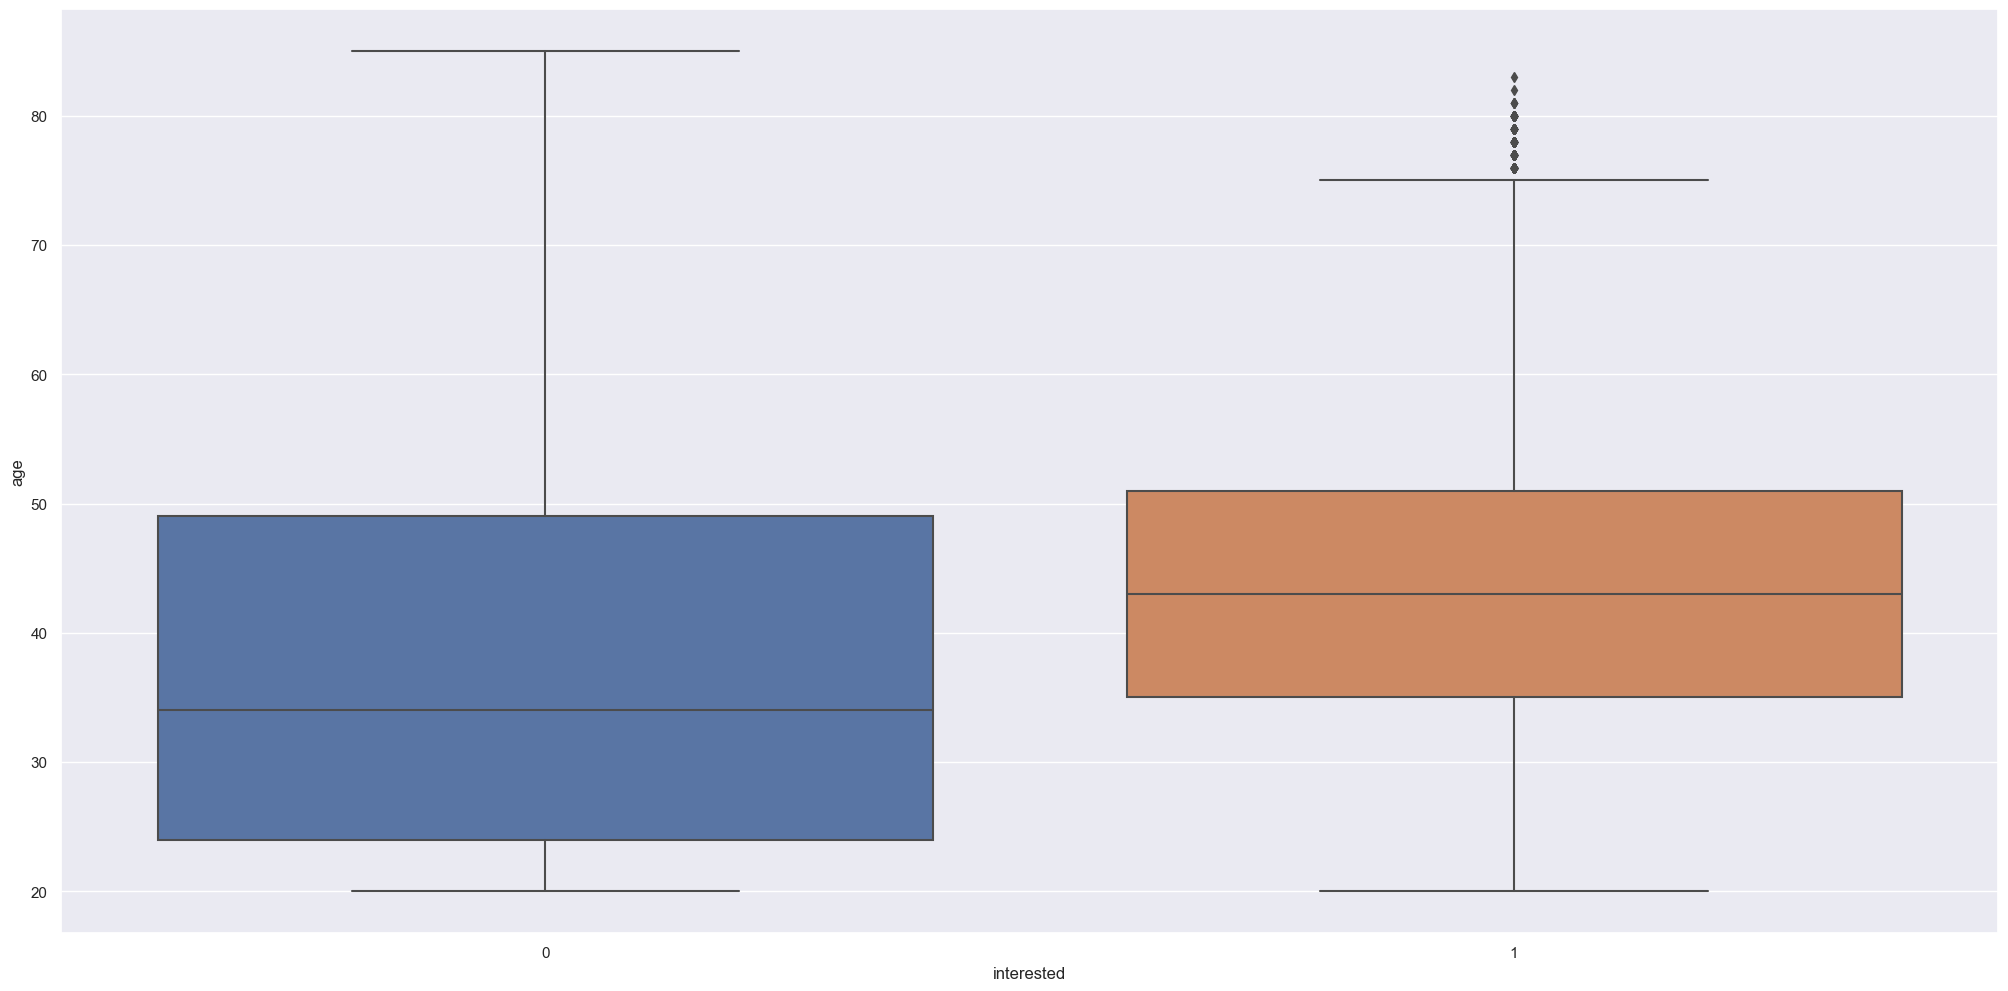

In [20]:
# age

sns.boxplot(x='interested',y='age',data=df4);

/Users/luishmq/.pyenv/versions/3.8.13/envs/insurance_cross_sell/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/luishmq/.pyenv/versions/3.8.13/envs/insurance_cross_sell/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/luishmq/.pyenv/versions/3.8.13/envs/insurance_cross_sell/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

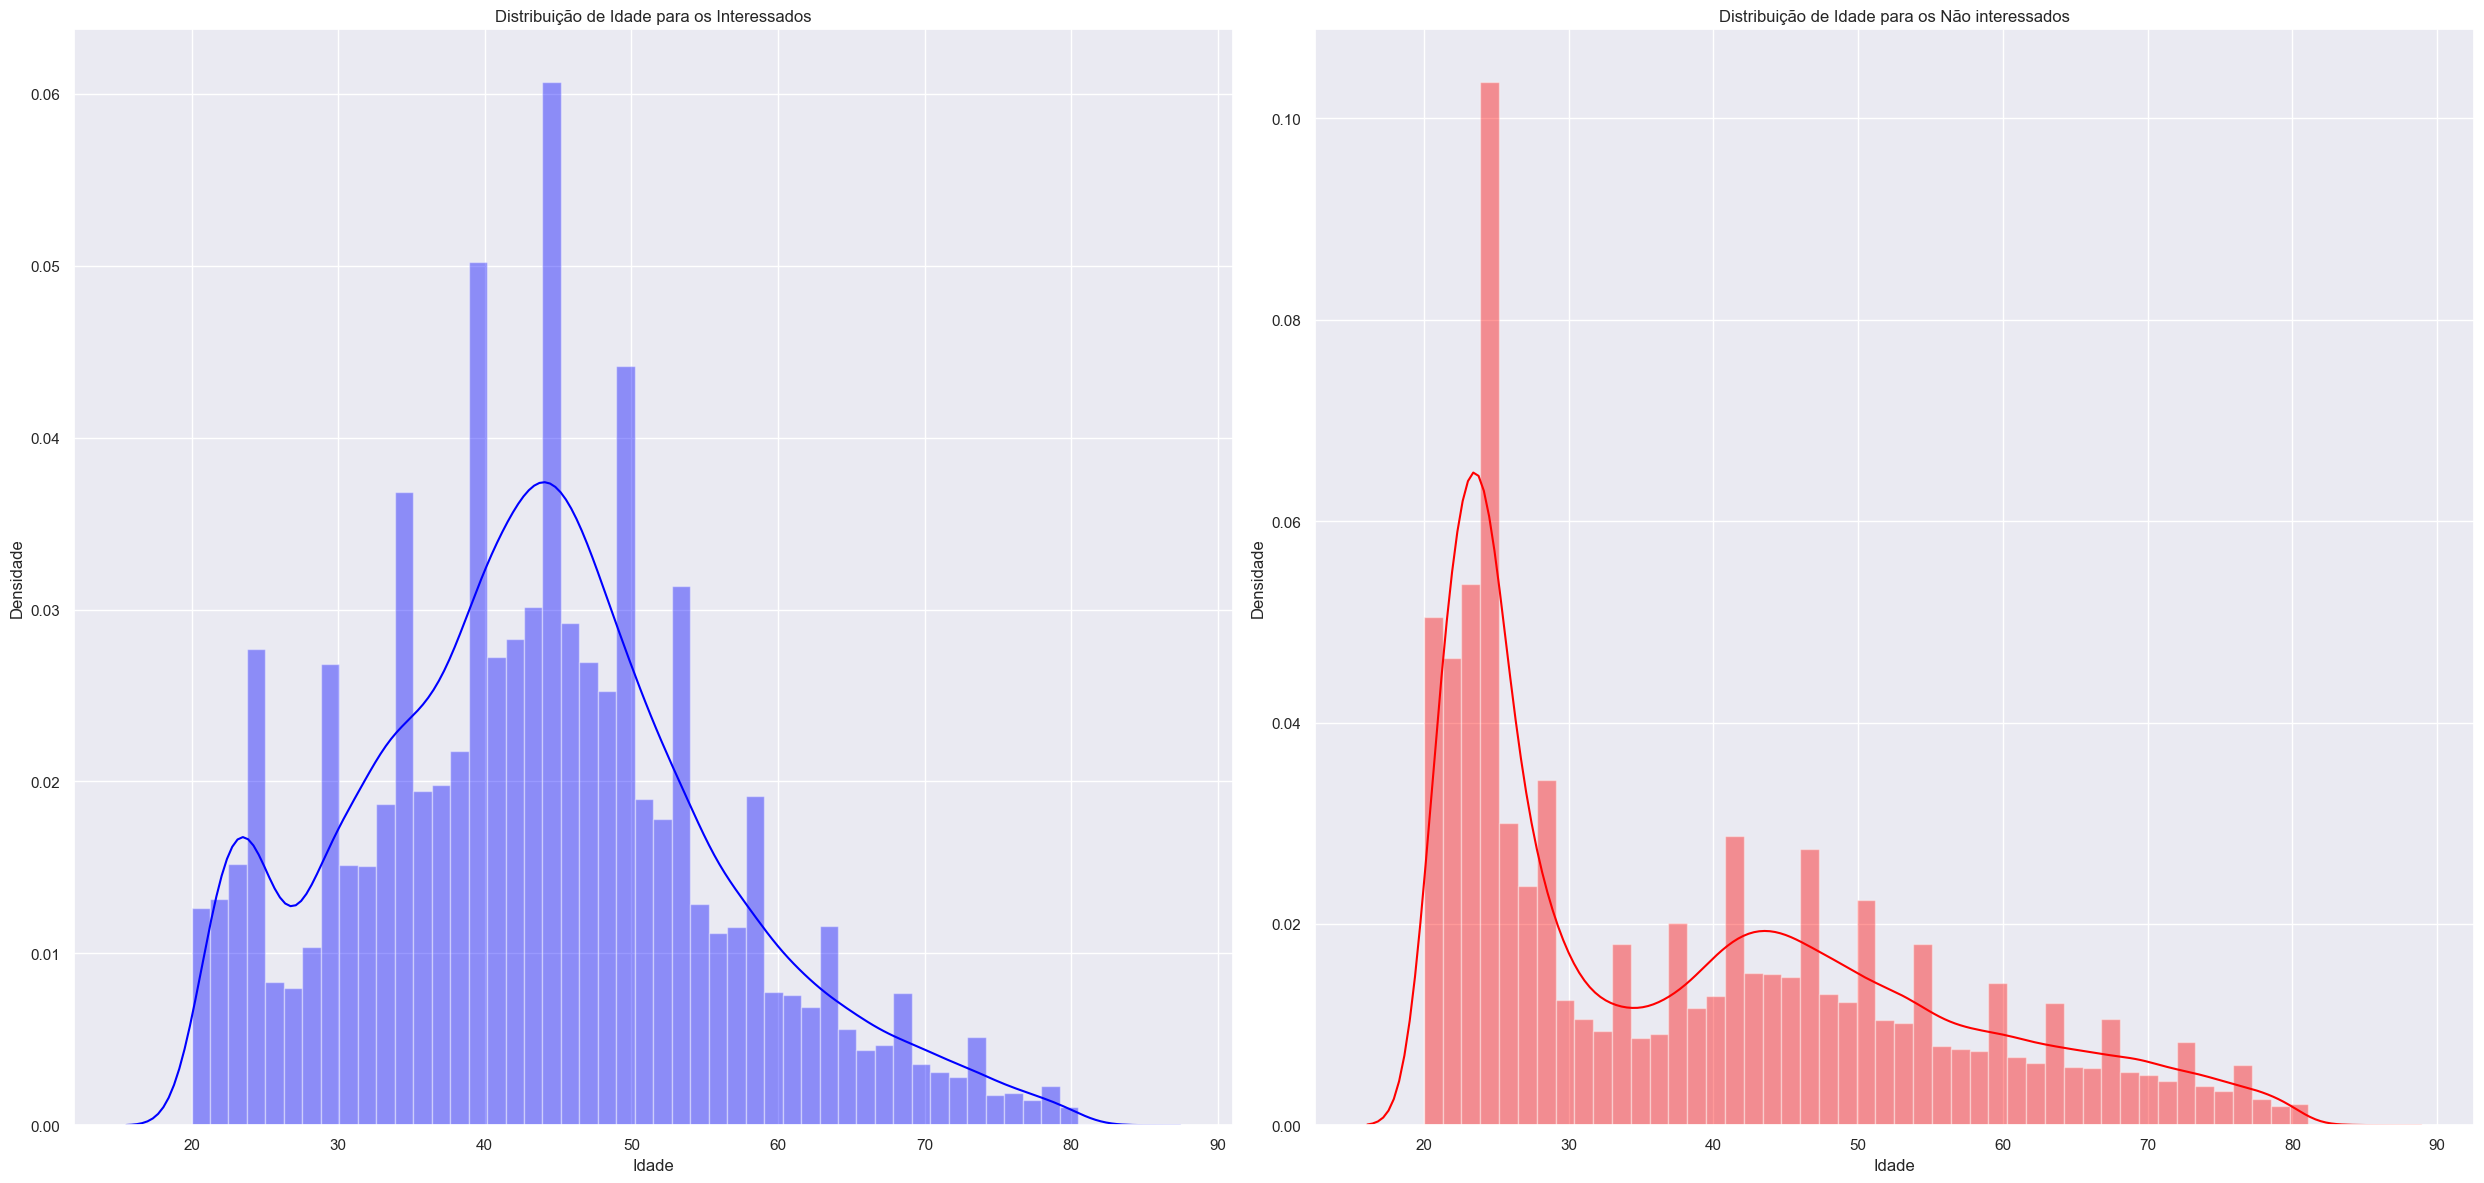

In [21]:
data = df4['age'].loc[df4['interested'] == 1]

sns.distplot( data )

data_1 = df4['age'].loc[df4['interested'] == 1]
data_0 = df4['age'].loc[df4['interested'] == 0]

plt.subplot(1, 2, 1)
sns.distplot(data_1, color='blue', label='Interessados')
plt.title('Distribuição de Idade para os Interessados')
plt.xlabel('Idade')
plt.ylabel('Densidade')

plt.subplot(1, 2, 2)
sns.distplot(data_0, color='red', label='Não interessados')
plt.title('Distribuição de Idade para os Não interessados')
plt.xlabel('Idade')
plt.ylabel('Densidade')

# Exibir os gráficos
plt.tight_layout()
plt.show()

### 4.2.2 Annual premium

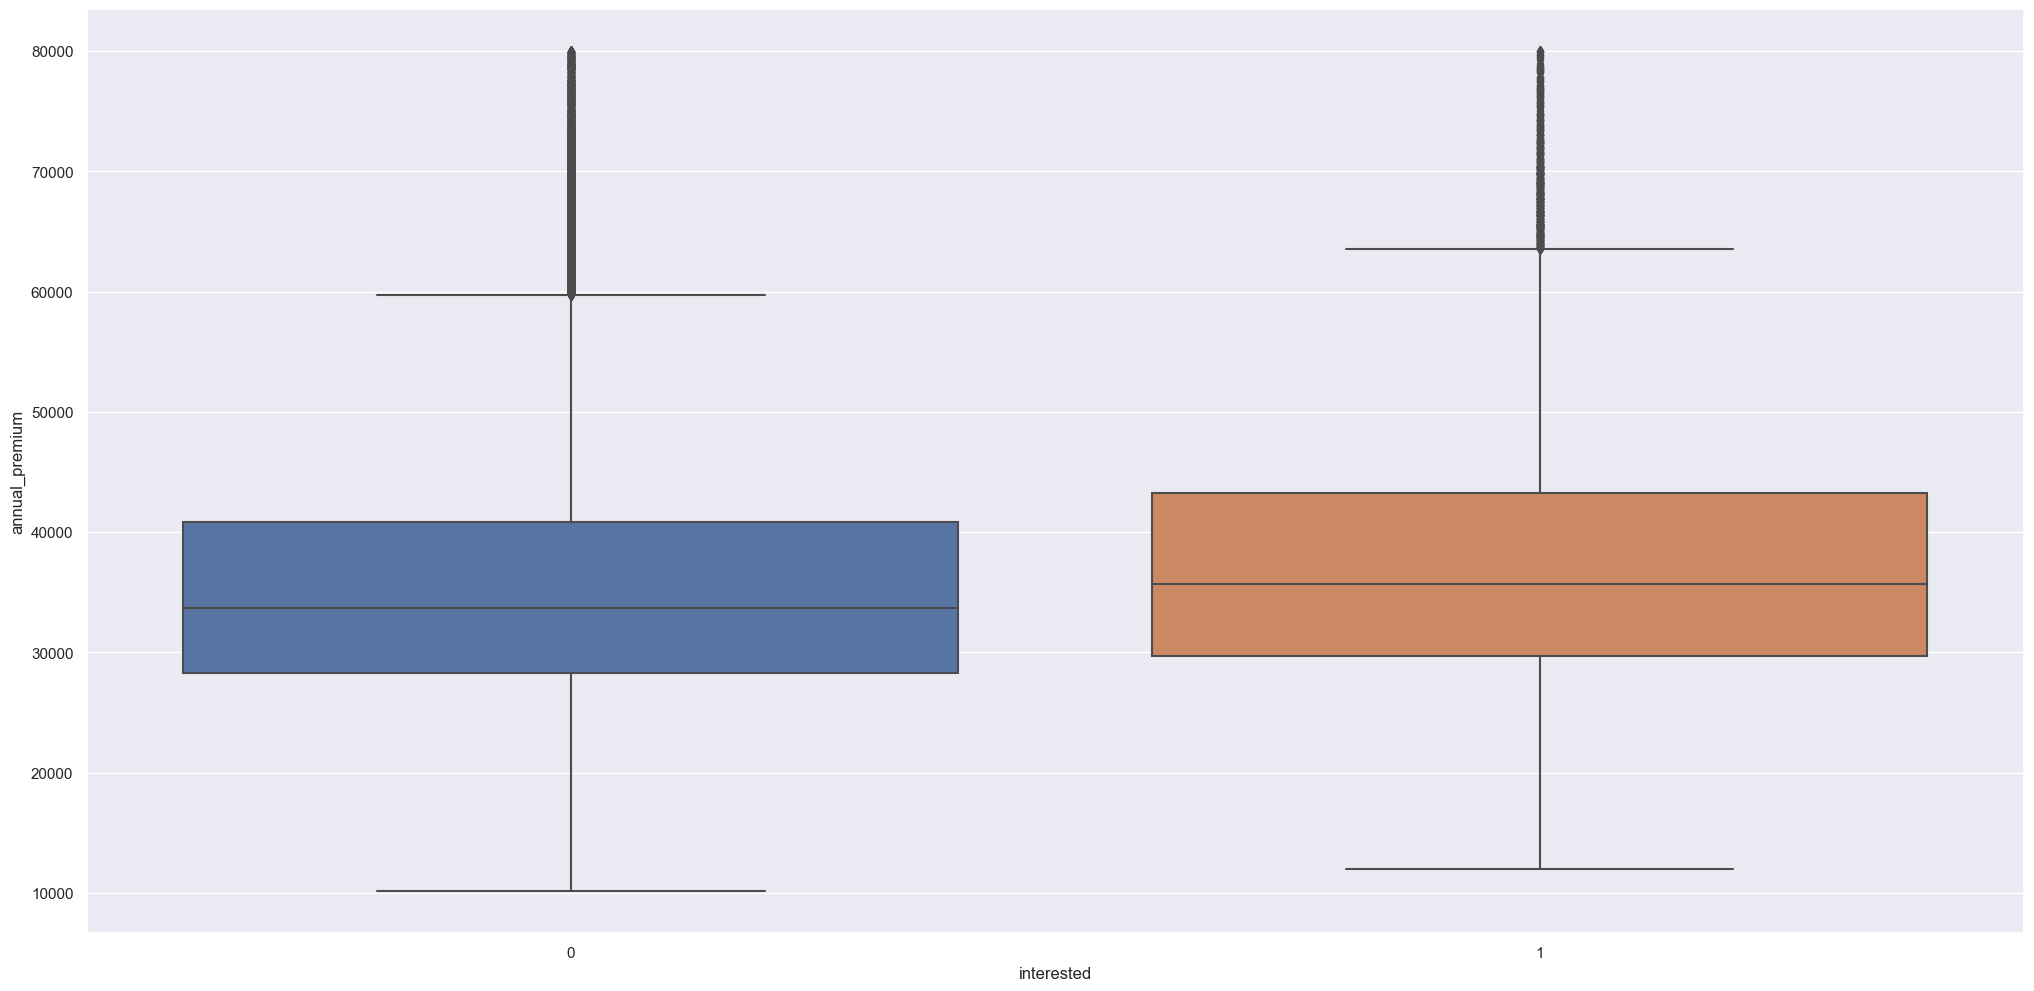

In [22]:
# annual_premium

aux = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]
sns.boxplot(x='interested',y='annual_premium',data=aux);

### 4.2.3 Days Client Associate

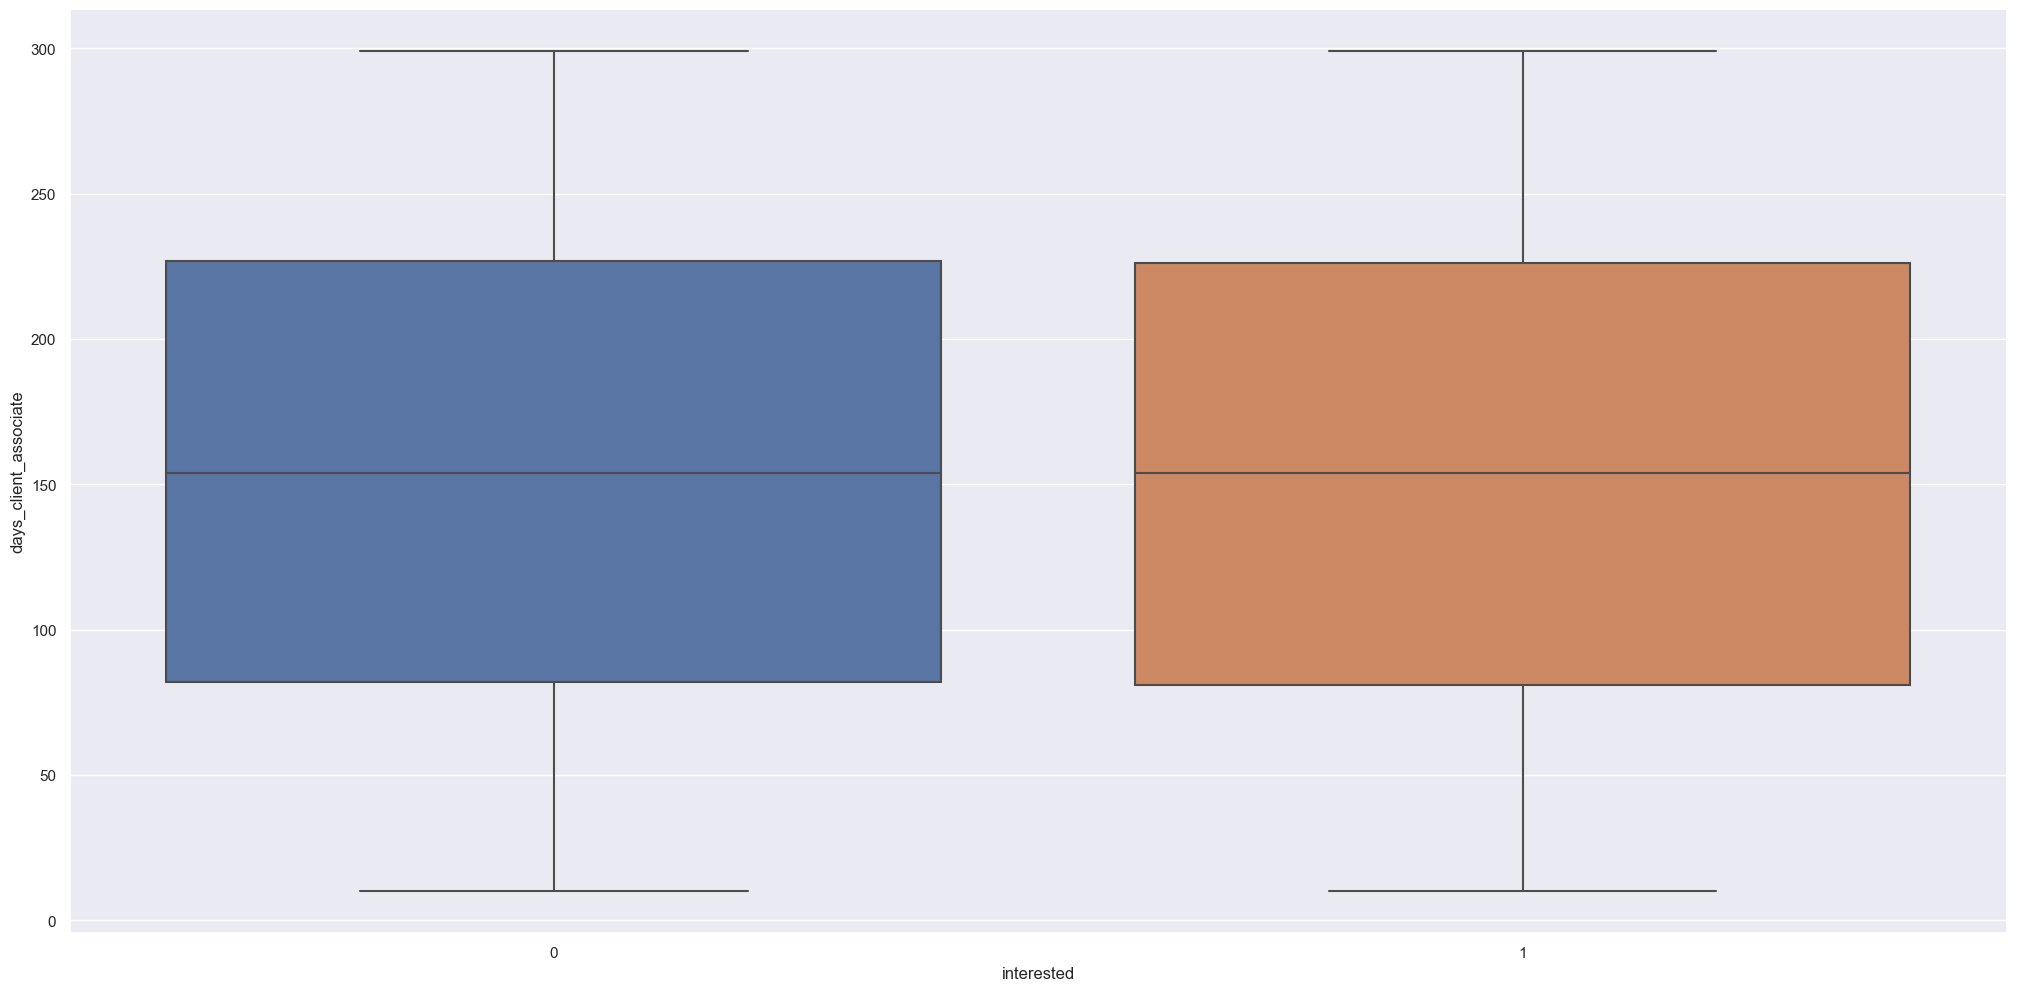

In [23]:
# days_client_associate

sns.boxplot(x='interested',y='days_client_associate',data=df4);

### 4.2.4 Sales Channel

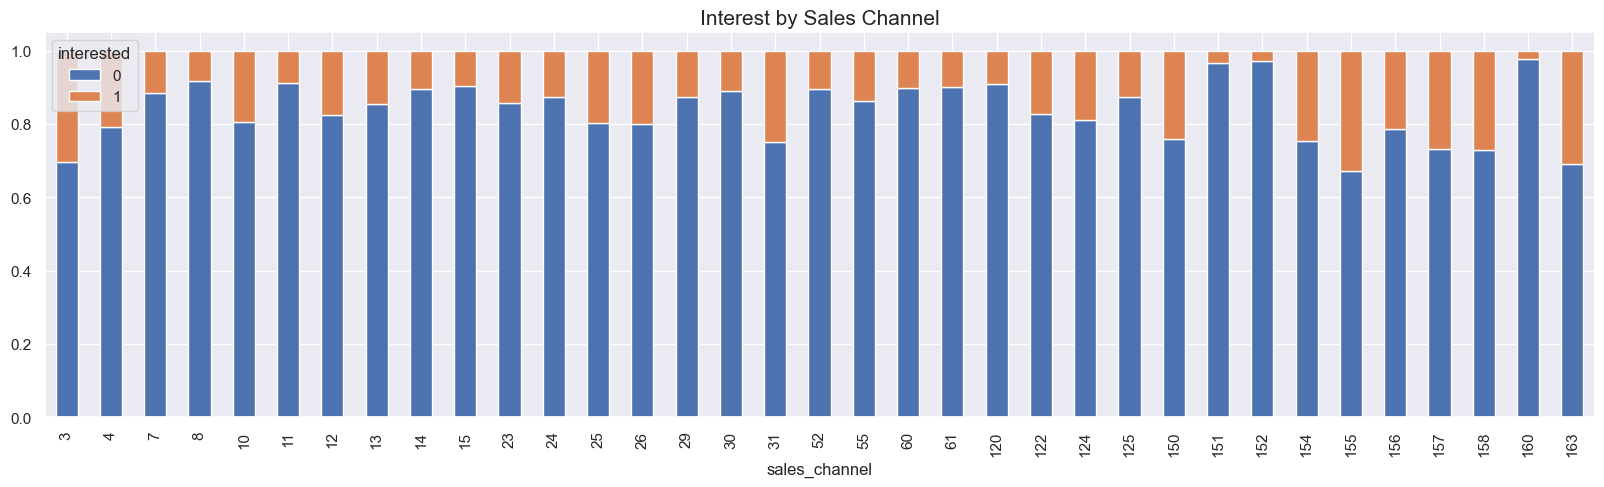

In [24]:
# sales_channel

aux = df4[["sales_channel", "interested"]].groupby('sales_channel').sum().reset_index()
aux = aux[aux['interested'] > 40]

aux2 = df4[df4['sales_channel'].isin(aux['sales_channel'])]
df_grouped = aux2[["sales_channel", "interested"]].groupby('sales_channel').value_counts(normalize=True).unstack('interested')
df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Sales Channel',fontsize=15);

### 4.2.5 Region Code

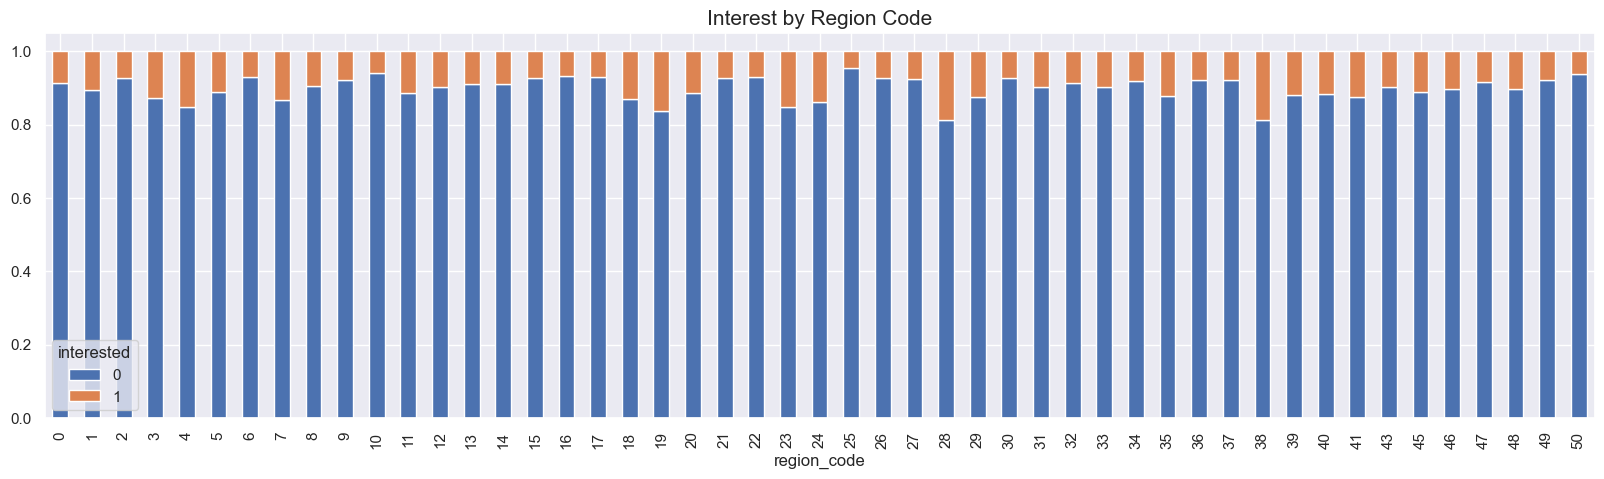

In [25]:
# region_code

aux = df4[["region_code", "interested"]].groupby('region_code').sum().reset_index()
aux = aux[aux['interested'] > 40]

aux2 = df4[df4['region_code'].isin(aux['region_code'])]
df_grouped = aux2[["region_code", "interested"]].groupby('region_code').value_counts(normalize=True).unstack('interested')
df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Region Code',fontsize=15);

### 4.2.6 Vehicle Age

- Pessoas com veículo novos ( < 1 ano ) tendem a não se interessarem em adquirir um seguro de automóvel.

In [26]:
# vehicle_age

pd.crosstab(df4['vehicle_age'], df4['interested']).apply(lambda x: x / x.sum(), axis=1)

interested,0,1
vehicle_age,,
bellow_1_year,0.956095,0.043905
between_1_2_year,0.826343,0.173657
over_2_years,0.707165,0.292835


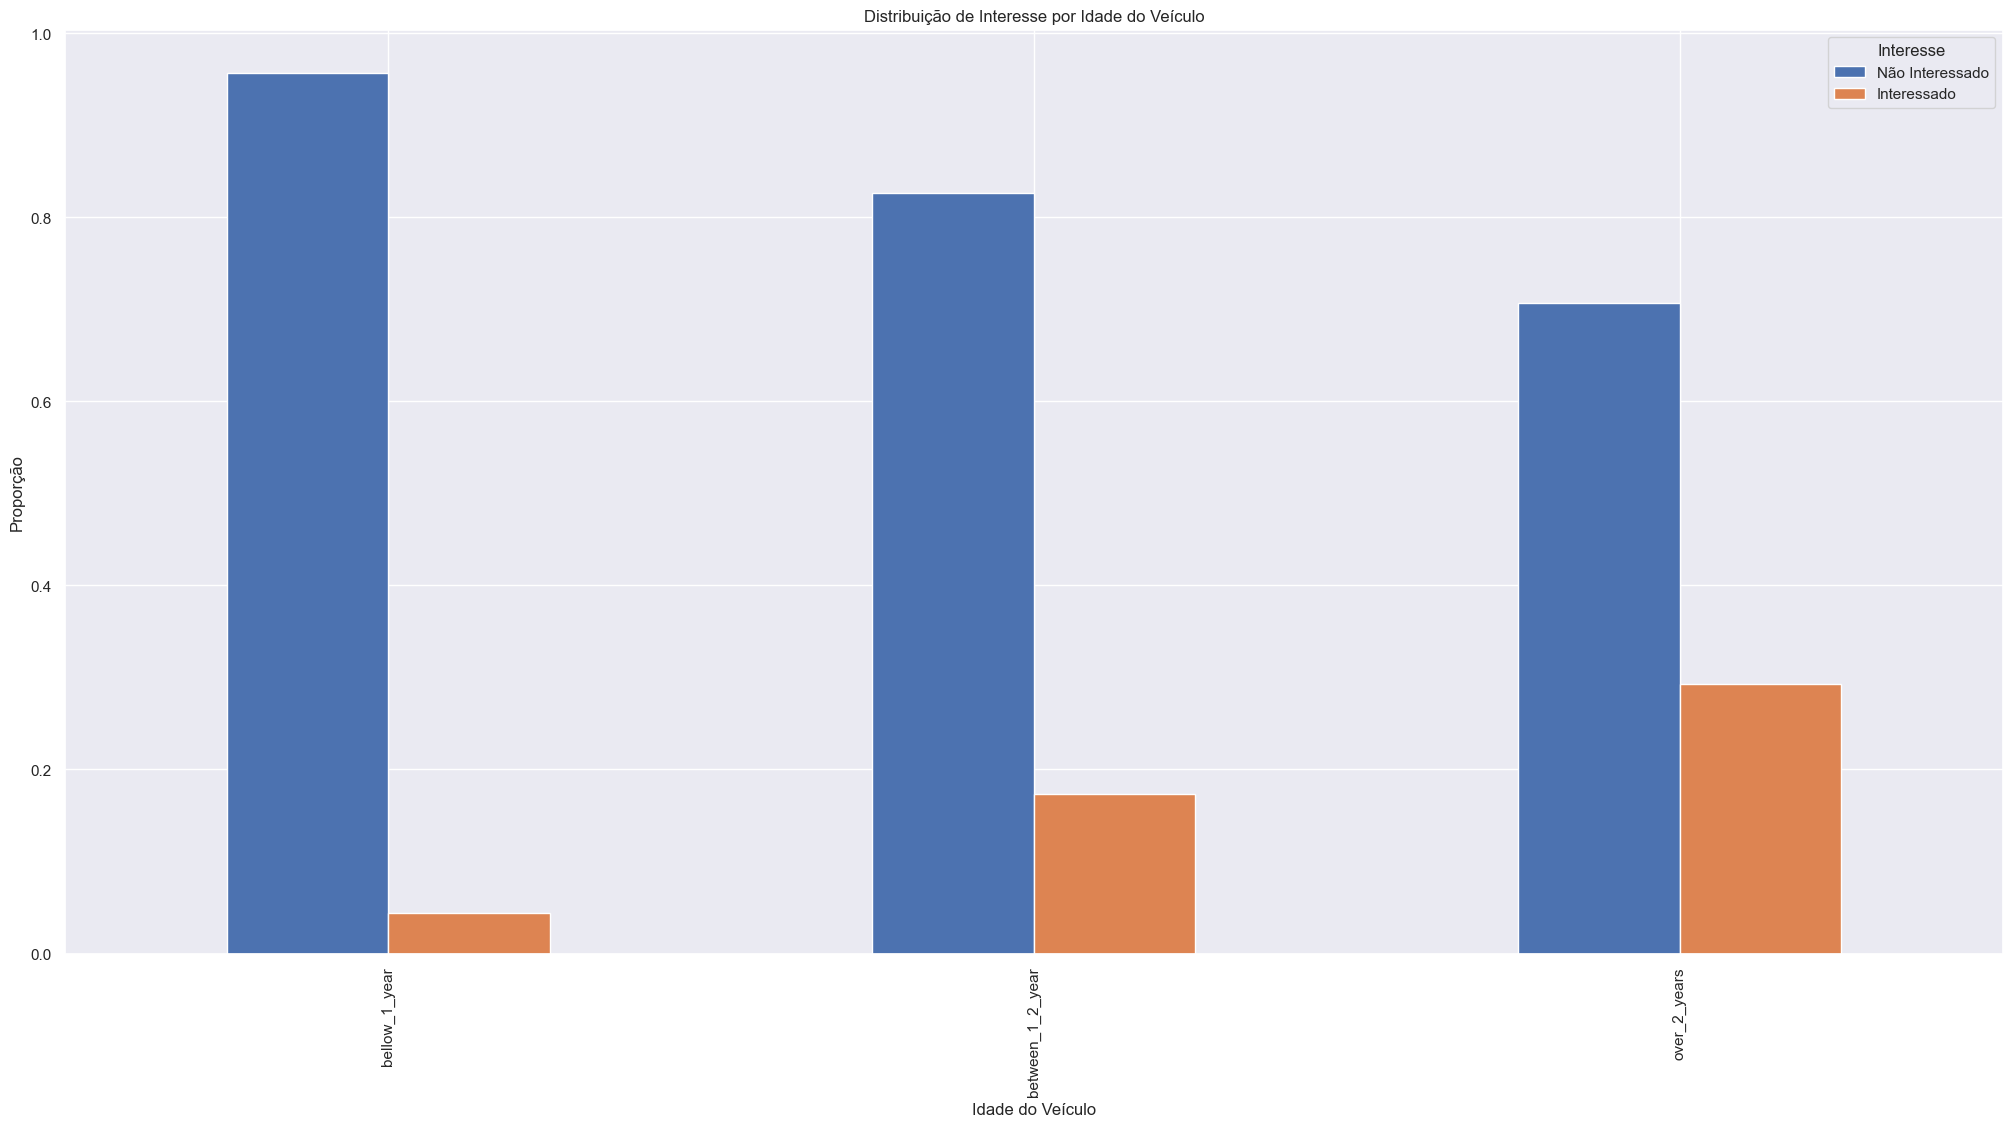

In [27]:
ct = pd.crosstab(df4['vehicle_age'], df4['interested']).apply(lambda x: x / x.sum(), axis=1)

ct.plot(kind='bar')
plt.title('Distribuição de Interesse por Idade do Veículo')
plt.xlabel('Idade do Veículo')
plt.ylabel('Proporção')
plt.legend(title='Interesse', labels=['Não Interessado', 'Interessado'])
plt.show()

### 4.2.7 Driving License

In [28]:
# driving_license

pd.crosstab(df4['driving_license'], df4['interested']).apply(lambda x: x / x.sum(), axis=1)

interested,0,1
driving_license,,
0,0.948012,0.051988
1,0.877285,0.122715


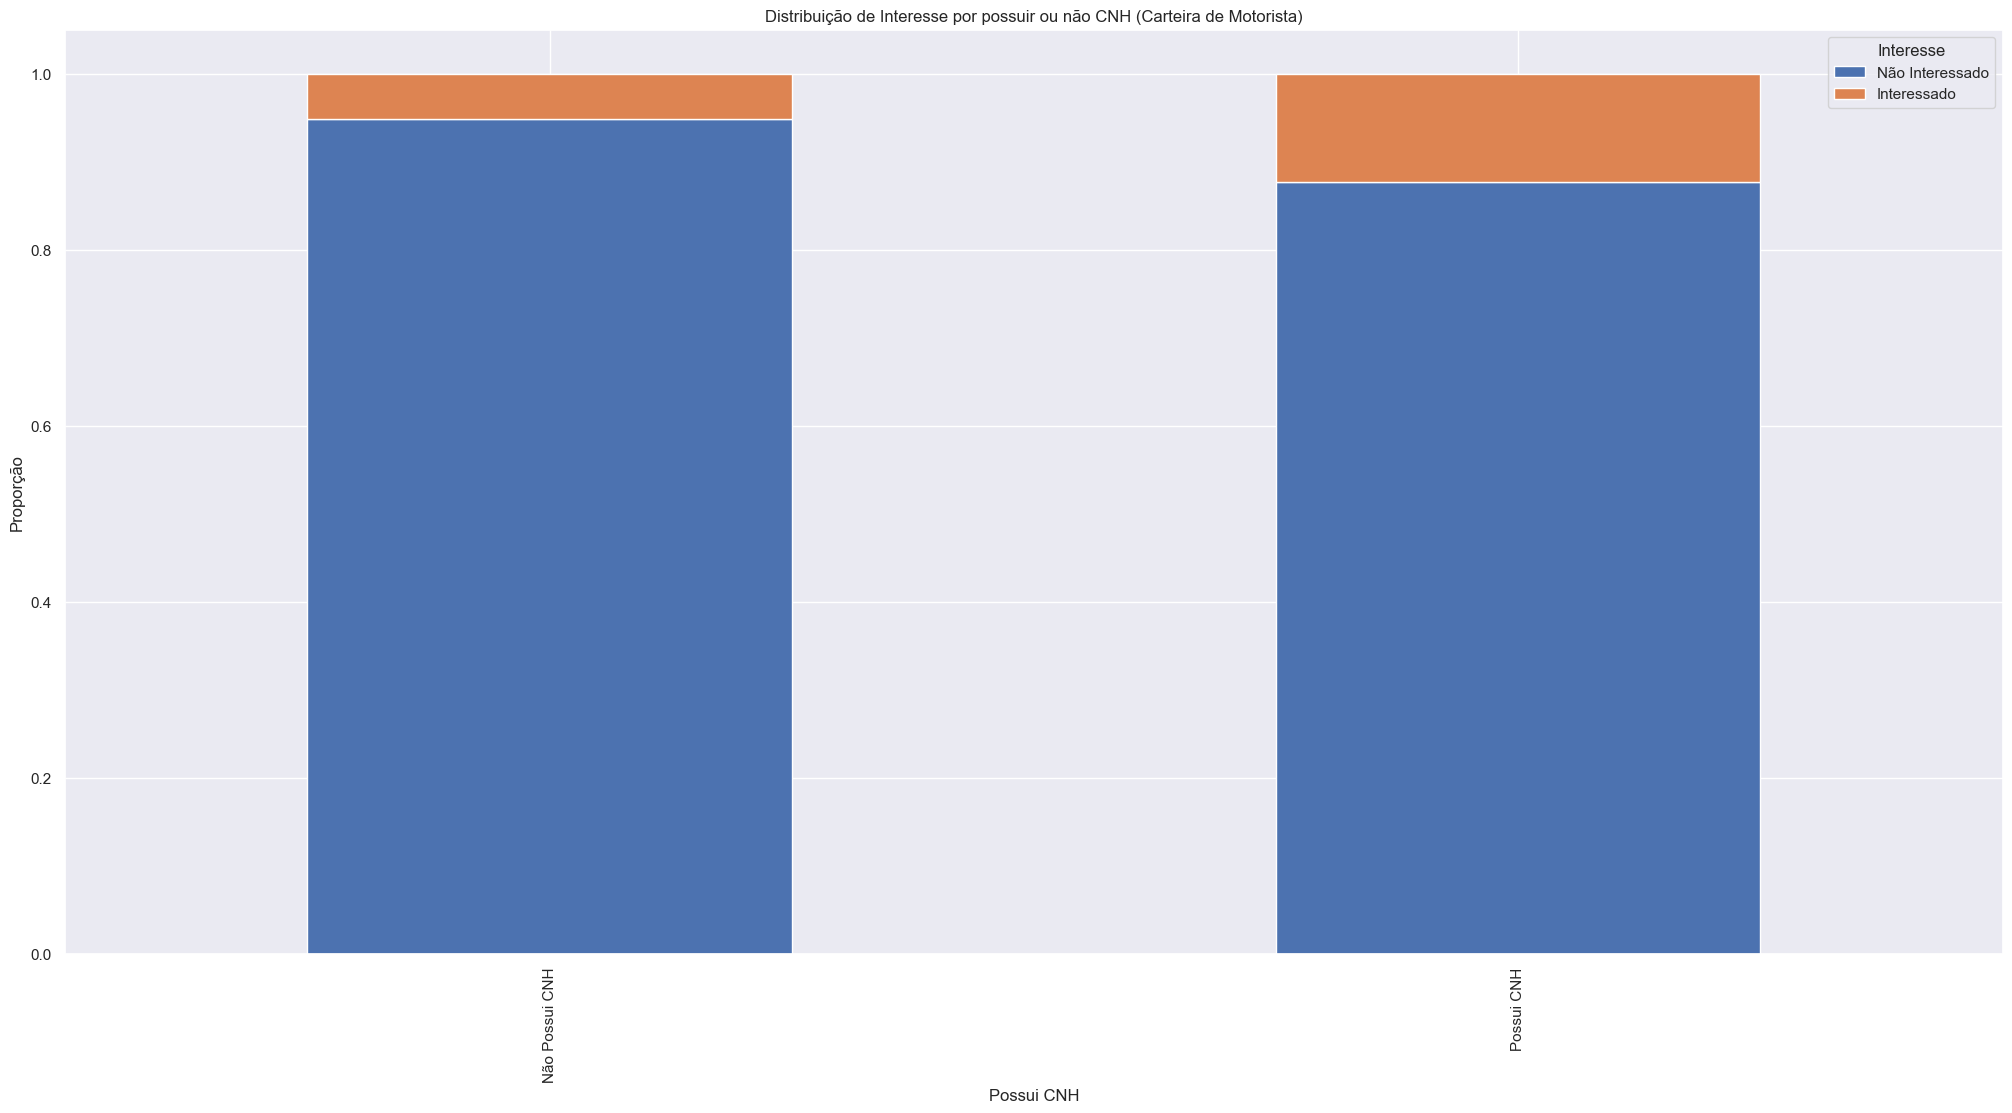

In [29]:
ct = pd.crosstab(df4['driving_license'], df4['interested']).apply(lambda x: x / x.sum(), axis=1)

ct.plot(kind='bar', stacked=True)
plt.title('Distribuição de Interesse por possuir ou não CNH (Carteira de Motorista)')
plt.xlabel('Possui CNH')
plt.ylabel('Proporção')
plt.legend(title='Interesse', labels=['Não Interessado', 'Interessado'])
plt.xticks(ticks=[0, 1], labels=['Não Possui CNH', 'Possui CNH'])
plt.show()

### 4.2.8 Gender

In [30]:
# gender

pd.crosstab(df4['gender'], df4['interested']).apply(lambda x: x / x.sum(), axis=1)

interested,0,1
gender,,
Female,0.895673,0.104327
Male,0.861931,0.138069


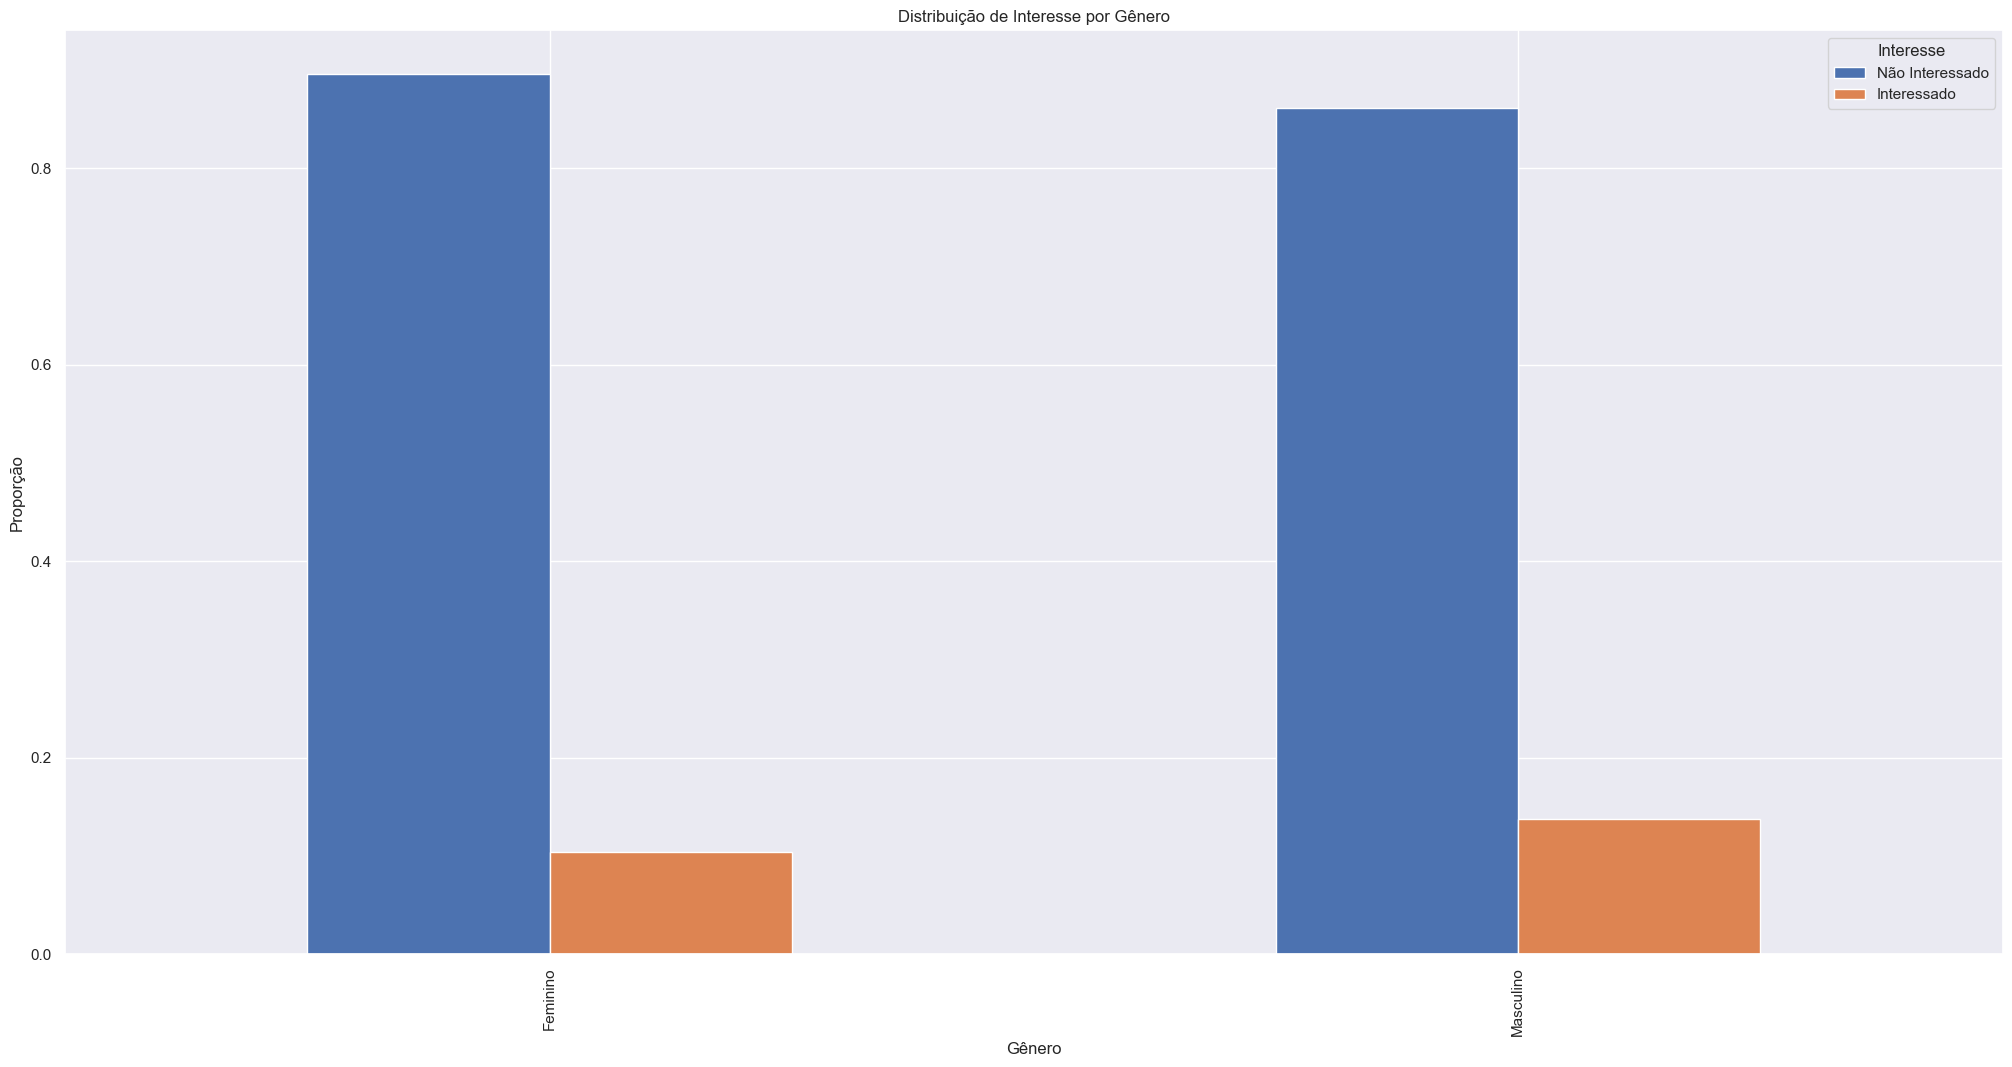

In [31]:
ct = pd.crosstab(df4['gender'], df4['interested']).apply(lambda x: x / x.sum(), axis=1)

ct.plot(kind='bar')
plt.title('Distribuição de Interesse por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Proporção')
plt.legend(title='Interesse', labels=['Não Interessado', 'Interessado'])
plt.xticks(ticks=[0, 1], labels=['Feminino', 'Masculino'])
plt.show()

### 4.2.9 Vehicle Insured

- É possível afirmar que pessoas que já possuem seguro não tem interesse em adquirir um seguro de automóvel.

In [32]:
# vehicle_insured

pd.crosstab(df4['vehicle_insured'], df4['interested']).apply(lambda x: x / x.sum(), axis=1)

interested,0,1
vehicle_insured,,
0,0.774529,0.225471
1,0.999155,0.000845


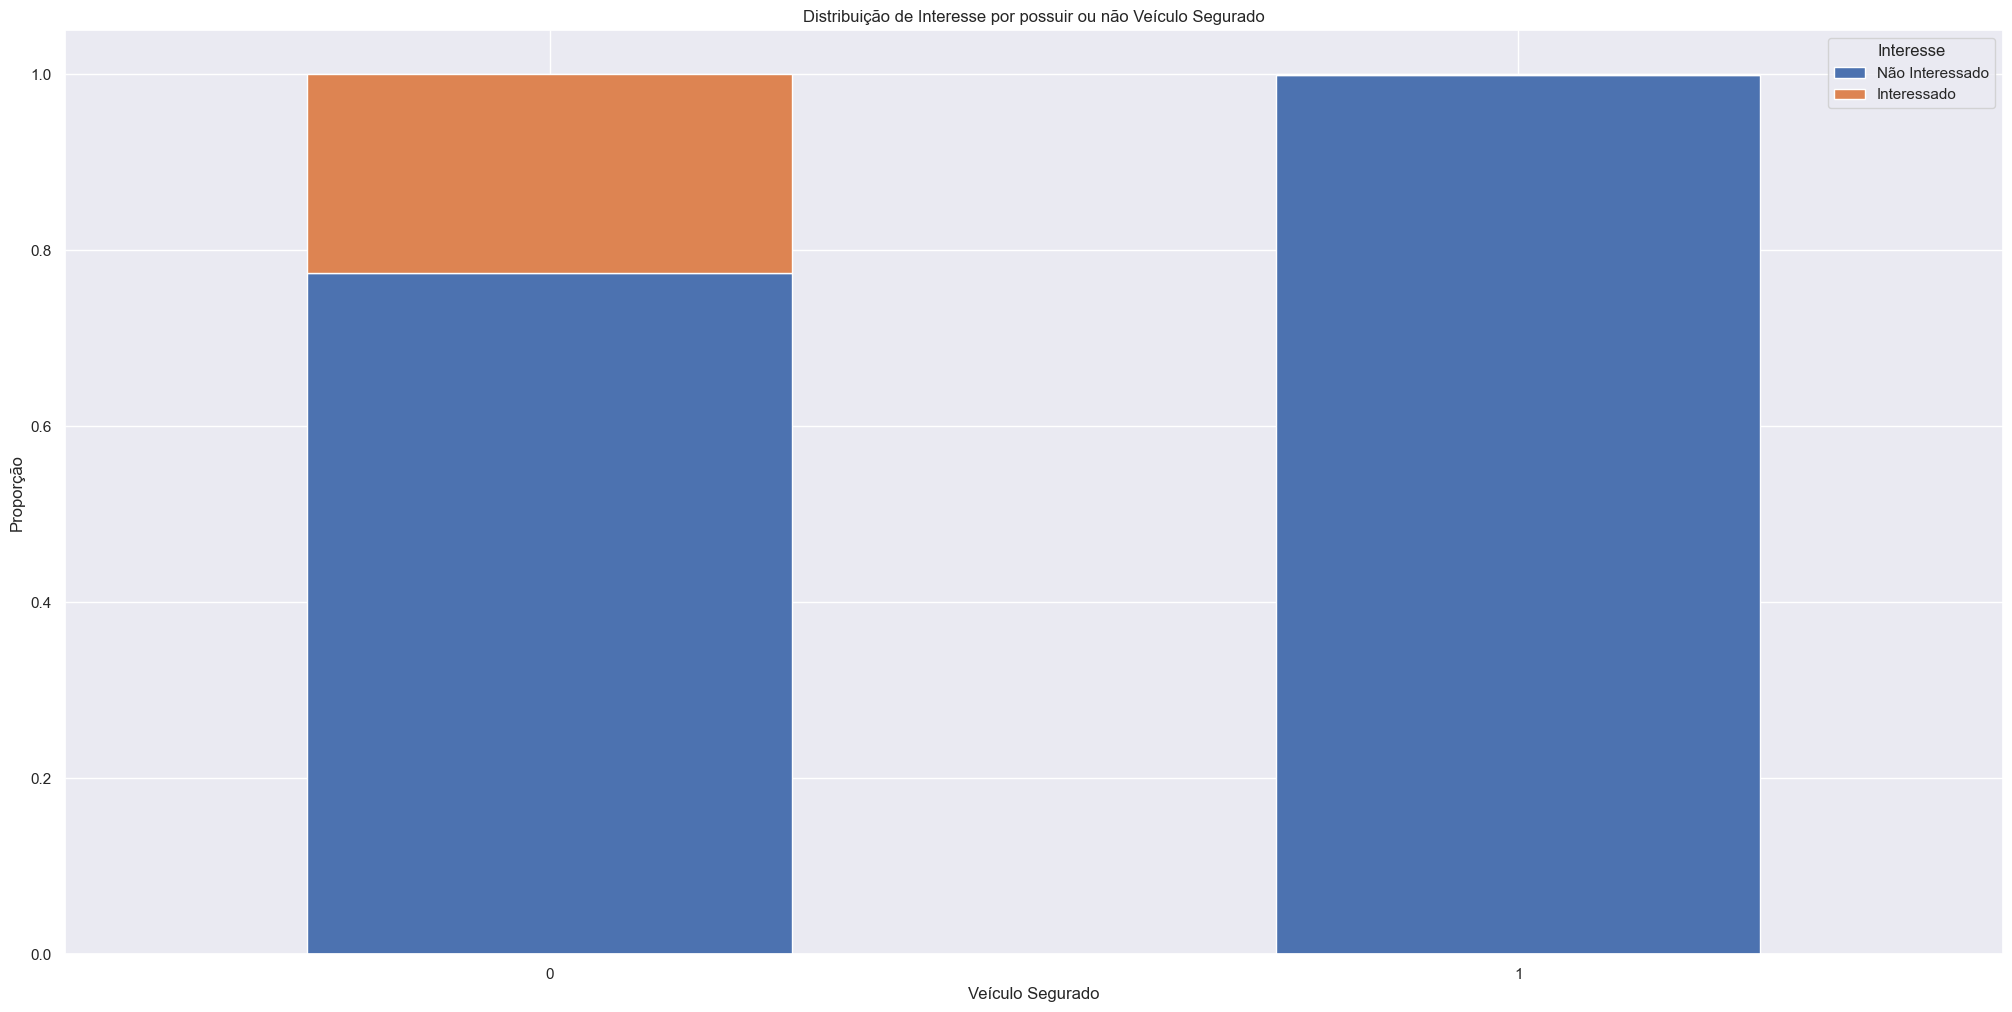

In [33]:
ct = pd.crosstab(df4['vehicle_insured'], df4['interested']).apply(lambda x: x / x.sum(), axis=1)

ct.plot(kind='bar', stacked=True)
plt.title('Distribuição de Interesse por possuir ou não Veículo Segurado')
plt.xlabel('Veículo Segurado')
plt.ylabel('Proporção')
plt.legend(title='Interesse', labels=['Não Interessado', 'Interessado'])
plt.xticks(rotation=0) 
plt.show()

### 4.2.10 Vehicle Damage

- É possível afirmar que pessoas que nunca tiveram seu carro danificado não tem interesse em adquirir um seguro de automóvel.

In [34]:
# vehicle_damage

pd.crosstab(df4['vehicle_damage'], df4['interested']).apply(lambda x: x / x.sum(), axis=1)

interested,0,1
vehicle_damage,,
0,0.994739,0.005261
1,0.762443,0.237557


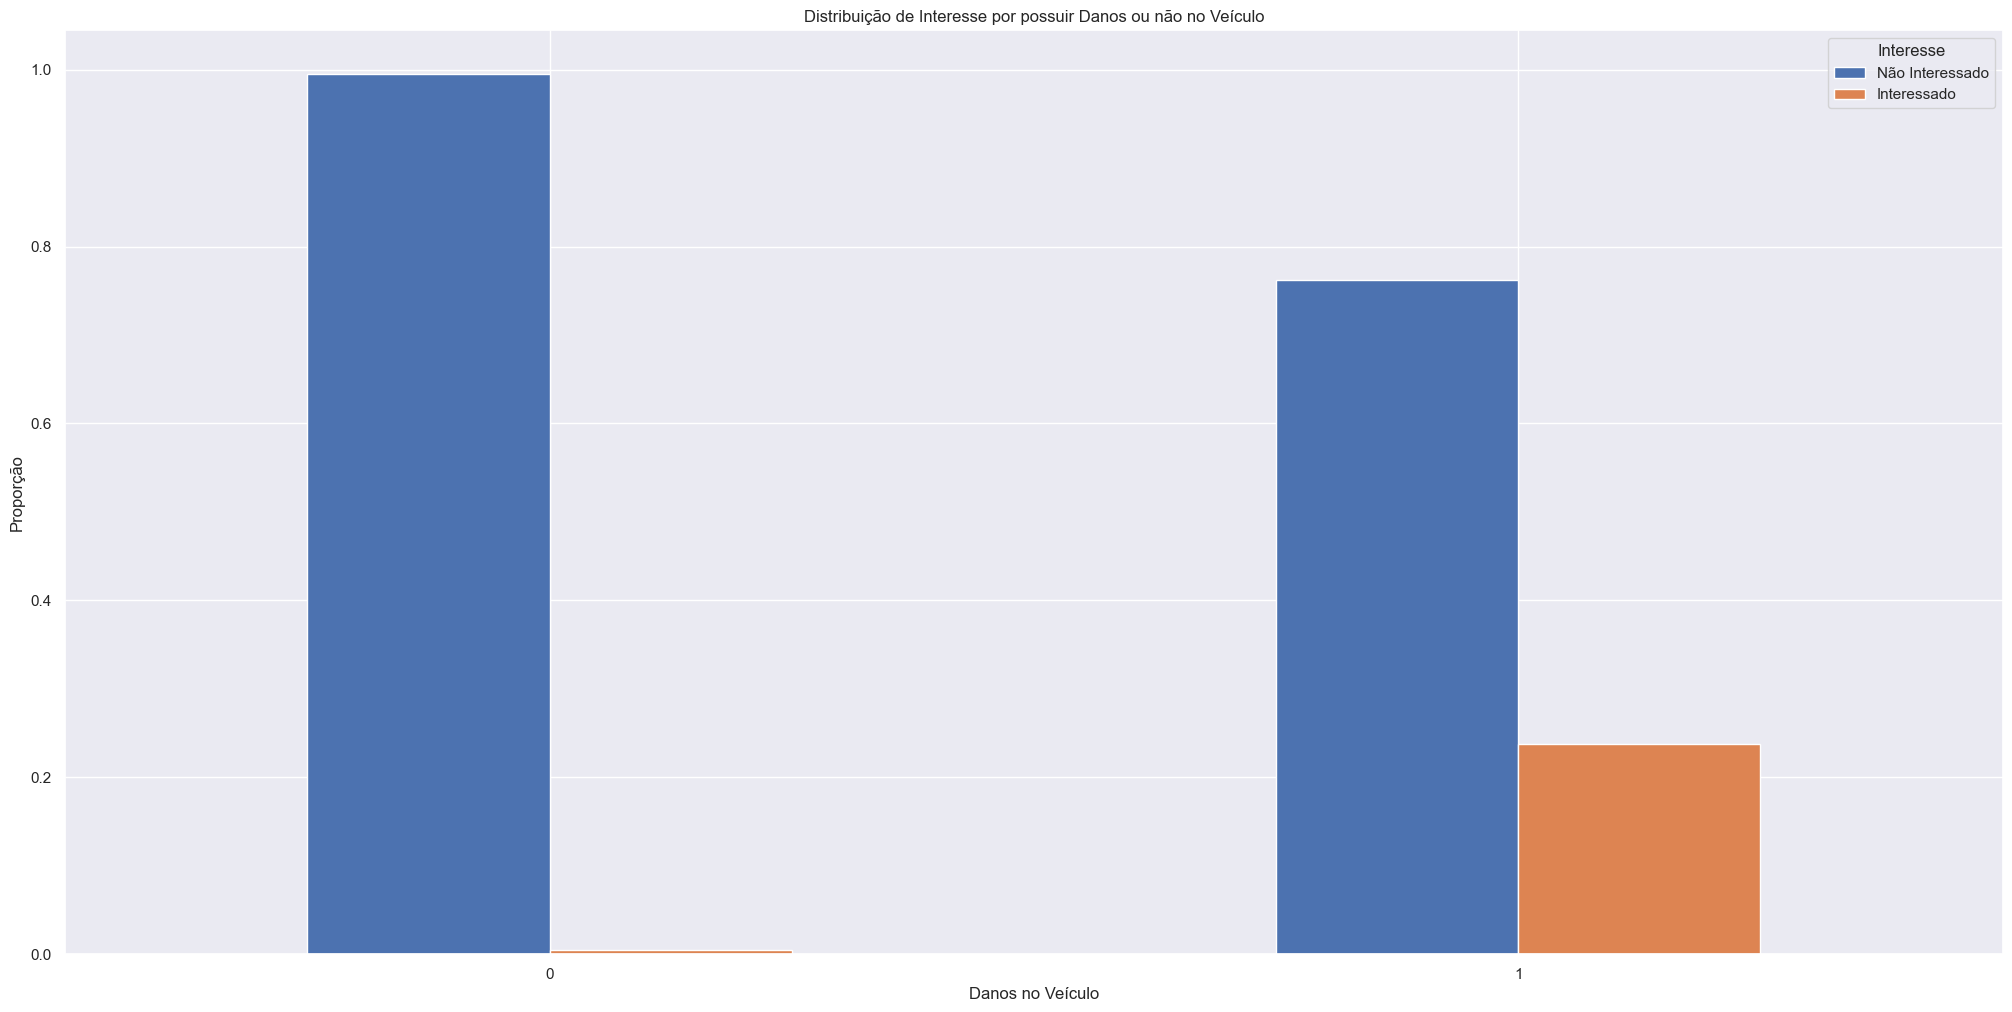

In [35]:
ct = pd.crosstab(df4['vehicle_damage'], df4['interested']).apply(lambda x: x / x.sum(), axis=1)

ct.plot(kind='bar')
plt.title('Distribuição de Interesse por possuir Danos ou não no Veículo')
plt.xlabel('Danos no Veículo')
plt.ylabel('Proporção')
plt.legend(title='Interesse', labels=['Não Interessado', 'Interessado'])
plt.xticks(rotation=0) 
plt.show()

## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

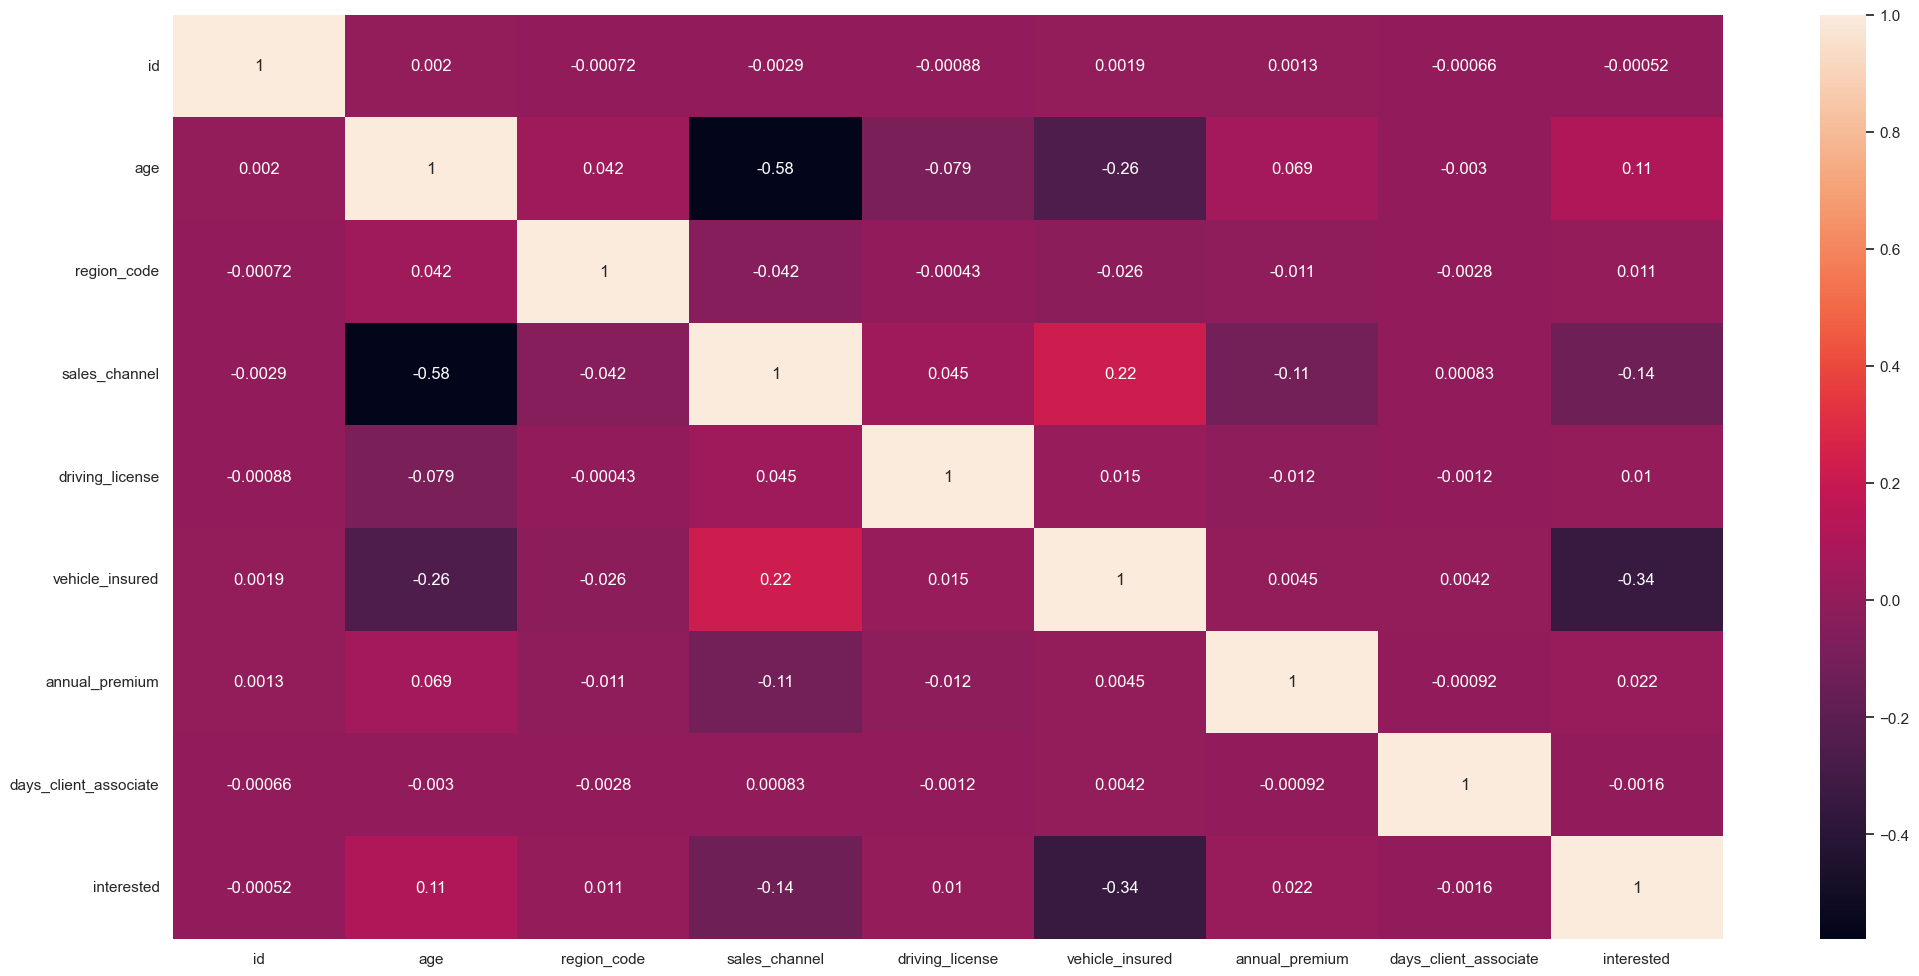

In [36]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

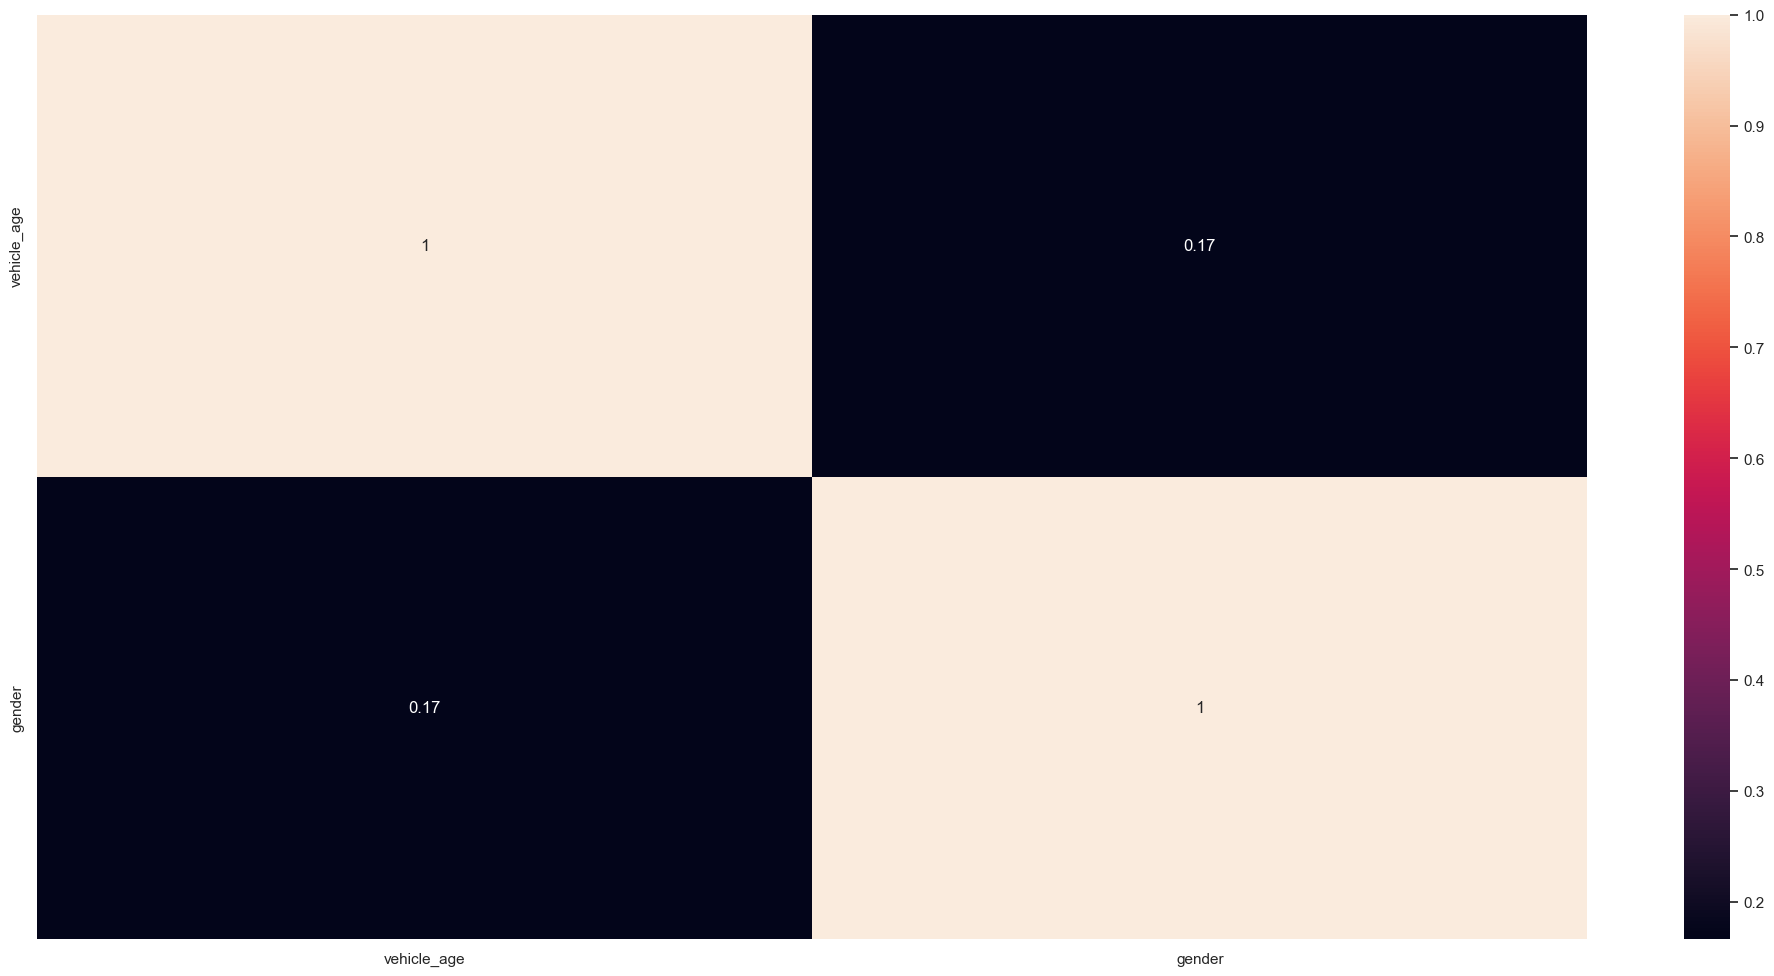

In [37]:
# Selecionando somente Dados Categóricos
cat = df4.select_dtypes(include='object')

# Calcula Cramer V
a1 = cramer_v(cat['vehicle_age'], cat['vehicle_age'])
a2 = cramer_v(cat['vehicle_age'], cat['gender'])

a3 = cramer_v(cat['gender'], cat['vehicle_age'])
a4 = cramer_v(cat['gender'], cat['gender'])

# Dataset Final
df = pd.DataFrame({'vehicle_age': [a1, a2],
                   'gender': [a3, a4],
                  })
df = df.set_index(df.columns)

# Mapa de Calor para verificar a correlação entre as variáveis categóricas
sns.heatmap(df, annot=True);

# 5.0 Data Preparation

In [38]:
df5 = df4.copy()

In [39]:
X = df5.drop('interested', axis=1)
y = df5['interested'].copy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

df5 = pd.concat([X_train, y_train], axis=1)

## 5.1 Standardization

In [40]:
ss = StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('/Users/luishmq/Documents/repos/insurance_cross_sell/src/features/annual_premium.pkl','wb'))

## 5.2 Rescaling

In [41]:
# MinMaxScaler

mms_age = pp.MinMaxScaler()
mms_days = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump(mms_age, open('/Users/luishmq/Documents/repos/insurance_cross_sell/src/features/age.pkl','wb'))

# days_client_associate
df5['days_client_associate'] = mms_days.fit_transform( df5[['days_client_associate']].values )
pickle.dump(mms_days, open('/Users/luishmq/Documents/repos/insurance_cross_sell/src/features/days_client_associate.pkl','wb'))

## 5.3 Encoding

### 5.3.1 One Hot Enconding

In [42]:
# vehicle_age
df5 = pd.get_dummies(df5, prefix='vehicle_age',columns=['vehicle_age'])

### 5.3.2 Target Enconding

In [43]:
# gender 
target_encode_gender = df5.groupby('gender')['interested'].mean()
df5.loc[:,'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('/Users/luishmq/Documents/repos/insurance_cross_sell/src/features/gender.pkl','wb'))

# region_code 
target_encode_region_code = df5.groupby('region_code')['interested'].mean()
df5.loc[:,'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('/Users/luishmq/Documents/repos/insurance_cross_sell/src/features/region_code.pkl','wb'))

# vehicle damage
target_encode_vehicle_damage = df5.groupby('vehicle_damage')['interested'].mean()
df5.loc[:,'vehicle_damage'] = df5['vehicle_damage'].map(target_encode_vehicle_damage)
pickle.dump(target_encode_vehicle_damage, open('/Users/luishmq/Documents/repos/insurance_cross_sell/src/features/vehicle_damage.pkl','wb'))

### 5.3.3 Frequency Enconding

In [44]:
# sales_channel 
fe_policy_sales_channel = df5.groupby('sales_channel').size()/len(df5)
df5.loc[:,'sales_channel'] = df5['sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('/Users/luishmq/Documents/repos/insurance_cross_sell/src/features/sales_channel.pkl','wb'))

# 6.0 Feature Selection

In [45]:
df6 = df5.copy()

## 6.1 Balancing data - Undersampling and Oversampling

In [46]:
# Definindo o ClusterCentroids
#cc = ClusterCentroids(random_state=42)

# Criando a amostra dos dados
#X_res, y_res = cc.fit_resample(df6.drop(columns=['interested'], axis=1), df6['interested'])

# SmoteTomek
X_res, y_res = SMOTETomek(random_state=42).fit_resample(df6.drop(columns=['interested'], axis=1), df6['interested'])

In [47]:
# Antes do balanceamento
print(y_train.value_counts())

0    214040
1     29869
Name: interested, dtype: int64


In [48]:
# Depois do balanceamento
print(y_res.value_counts())

0    185326
1    185326
Name: interested, dtype: int64


In [49]:
X_train = X_res
y_train = y_res

## 6.2 Test Data Preparation

In [50]:
# annual_premium
X_test['annual_premium'] = ss.transform( X_test[['annual_premium']].values )

# age
X_test['age'] = mms_age.transform(X_test[['age']].values )

# days_client_associate
X_test['days_client_associate'] = mms_days.transform( X_test[['days_client_associate']].values )

# vehicle_age
X_test = pd.get_dummies(X_test, prefix='vehicle_age',columns=['vehicle_age'])

# gender 
X_test.loc[:,'gender'] = X_test['gender'].map(target_encode_gender)

# region_code 
X_test.loc[:,'region_code'] = X_test['region_code'].map(target_encode_region_code)

# vehicle damage
X_test.loc[:,'vehicle_damage'] = X_test['vehicle_damage'].map(target_encode_vehicle_damage)

# sales_channel 
X_test.loc[:,'sales_channel'] = X_test['sales_channel'].map(fe_policy_sales_channel)

In [51]:
# fillna
X_test = X_test.fillna(0)

## 6.3 Ranking Best Features

Feature ranking:
                        feature  importance
0               vehicle_insured    0.183015
0                vehicle_damage    0.169201
0     vehicle_age_bellow_1_year    0.117185
0                           age    0.094113
0                 sales_channel    0.086738
0                annual_premium    0.080135
0         days_client_associate    0.080073
0                   region_code    0.074720
0                        gender    0.060567
0  vehicle_age_between_1_2_year    0.032874
0      vehicle_age_over_2_years    0.021028
0               driving_license    0.000352


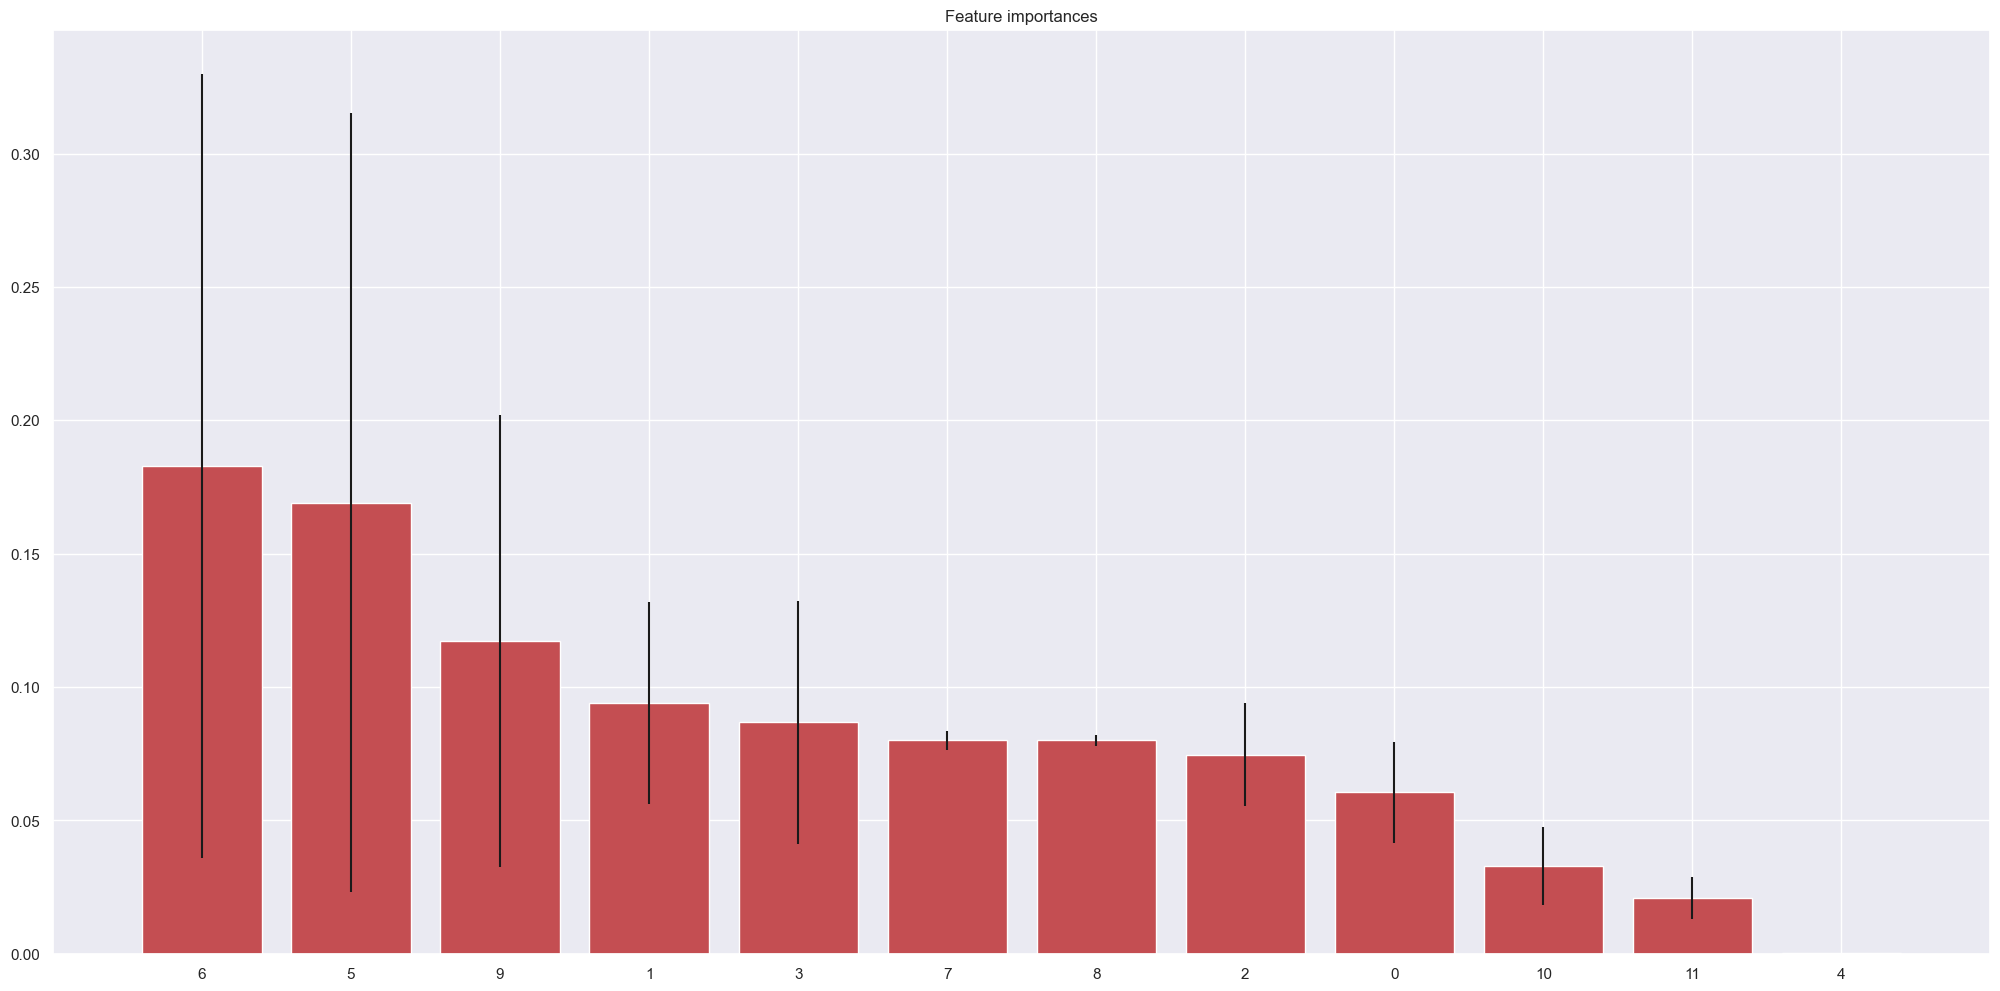

In [52]:
# Training model to rank features

forest = en.ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)
x_train_f = X_train.drop('id', axis=1)
y_train_f = y_train.values
forest.fit(x_train_f, y_train_f)

# Collect features from model selector
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Organize and print ranking per features
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_f, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_f.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_f.shape[1]), indices)
plt.xlim([-1, x_train_f.shape[1]])
plt.show()

# 7.0 Machine Learning Modeling

In [53]:
# select features from ML
cols_selected = ['gender', 'annual_premium', 'age', 'region_code',
                'vehicle_damage', 'sales_channel', 'vehicle_insured', 'vehicle_age_bellow_1_year', 'days_client_associate']

# Dataframe for ML
X_train_ml = X_train[cols_selected]
X_test_ml = X_test[cols_selected]

## 7.1 K-Nearest Neighbors

In [54]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(X_train_ml, y_train)

# model prediction - Generalization
yhat_knn = knn_model.predict_proba(X_test_ml)
yhatp_knn = knn_model.predict( X_test_ml )

### 7.1.1 K-Nearest Neighbors Score

In [55]:
knn_result_rank = ranking_performance('K-Nearest Neighbors', X_test_ml, y_test, yhat_knn, yhatp_knn, 50)
knn_result_rank

,Model Name,Precision at K,Recall at K,Accuracy,F1_score
0,K-Nearest Neighbors,0.411765,0.0028,0.770885,0.414582


### 7.1.2 K-Nearest Neighbors Score - CV

In [56]:
knn_result_cv = cross_validation( 'K-Nearest Neighbors', knn_model, X_train_ml, y_train, 5, verbose=False )
knn_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
K-Nearest Neighbors,1.0,0.0,0.855,0.861


### 7.1.3 Cumulative Gain Curve - KNN

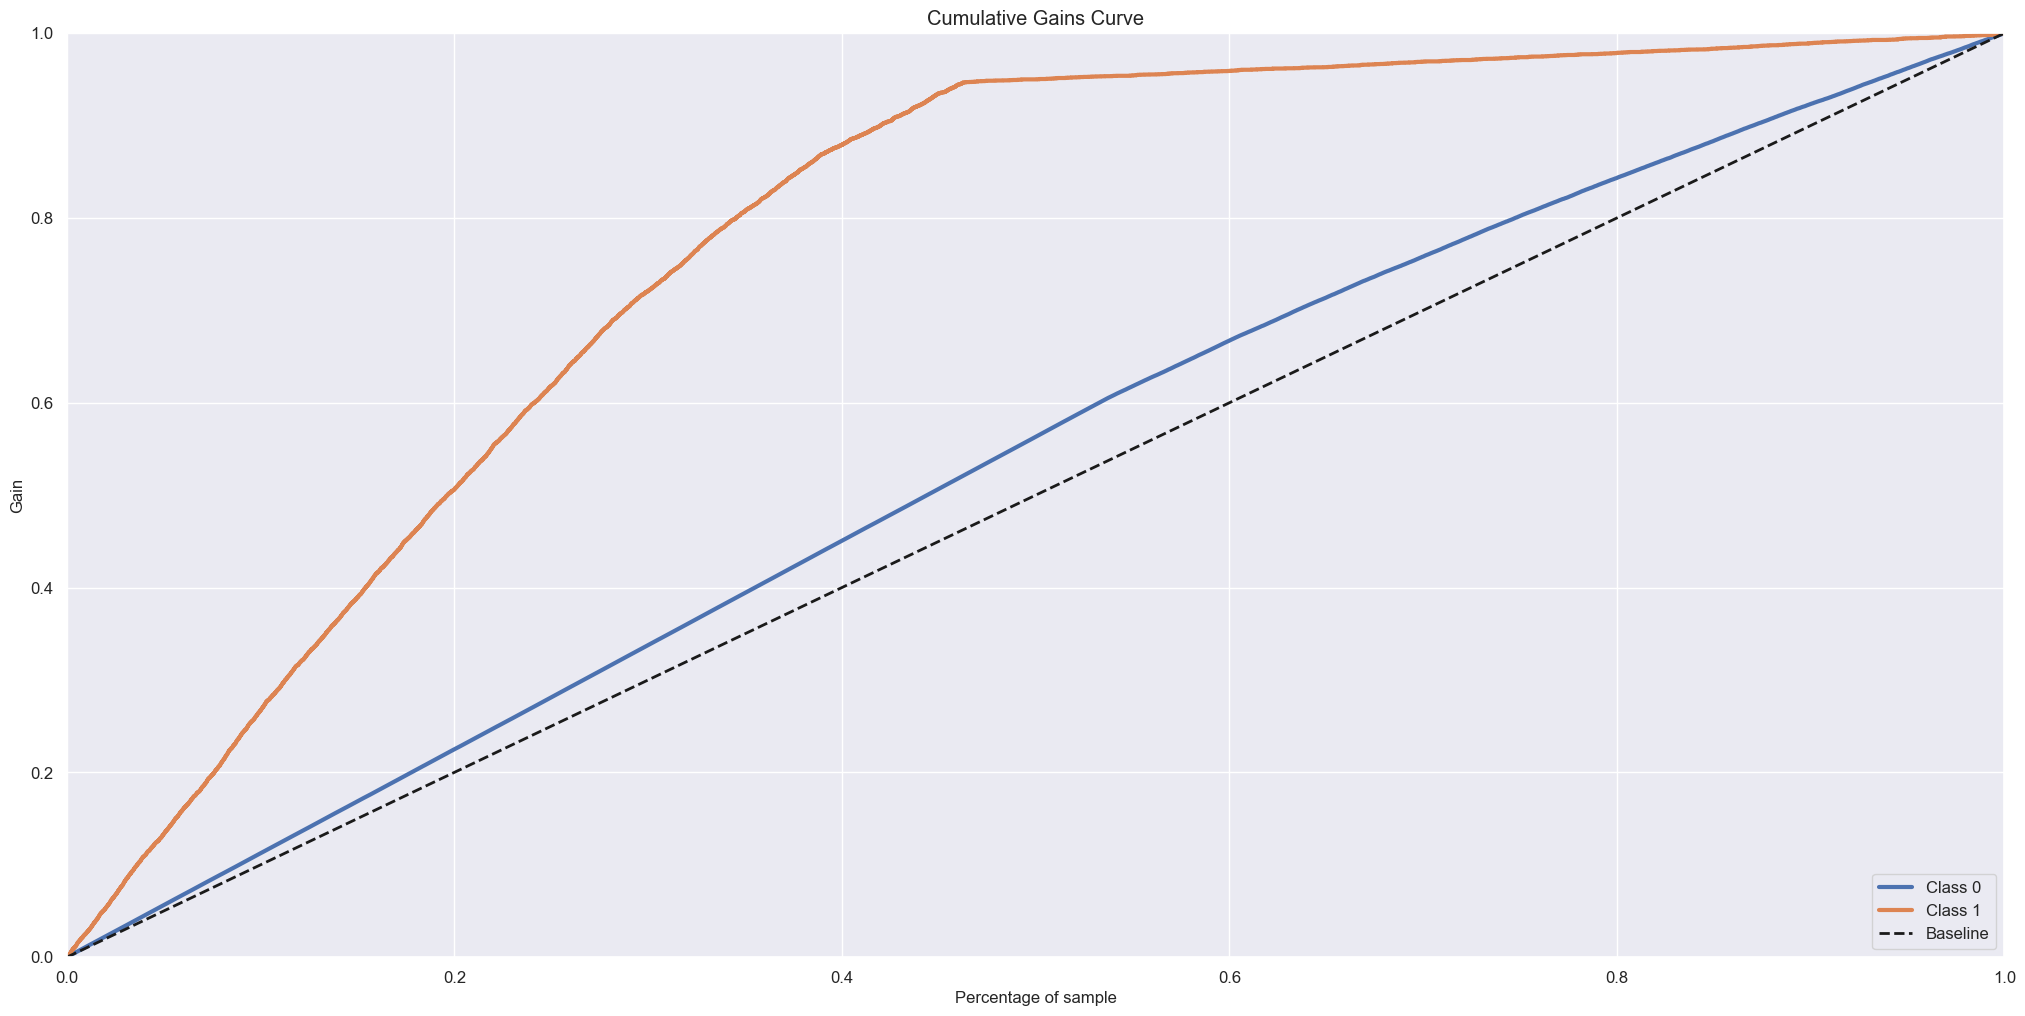

In [56]:
# Accumulative gain

plot_cumulative_gain(y_test, yhat_knn);

## 7.2 Logistic Regression

In [57]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( X_train_ml, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( X_test_ml )
yhatp_lr = lr_model.predict( X_test_ml )

### 7.2.1 Logistic Regression Score

In [115]:
lr_result_rank = ranking_performance('Logistic Regression', X_test_ml, y_test, yhat_lr, yhatp_lr, 50)
lr_result_rank

,Model Name,Precision at K,Recall at K,Accuracy,F1_score
0,Logistic Regression,0.058824,0.0004,0.729148,0.427204


### 7.2.2 Logistic Regression Score - CV

In [116]:
lr_result_cv = cross_validation( 'Logistic Regression', lr_model, X_train_ml, y_train, 5, verbose=False )
lr_result_cv

/Users/luishmq/.pyenv/versions/3.8.13/envs/insurance_cross_sell/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/luishmq/.pyenv/versions/3.8.13/envs/insurance_cross_sell/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver op

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
Logistic Regression,0.7,0.0,0.843,0.857


### 7.2.3 Cumulative Gain Curve - LR

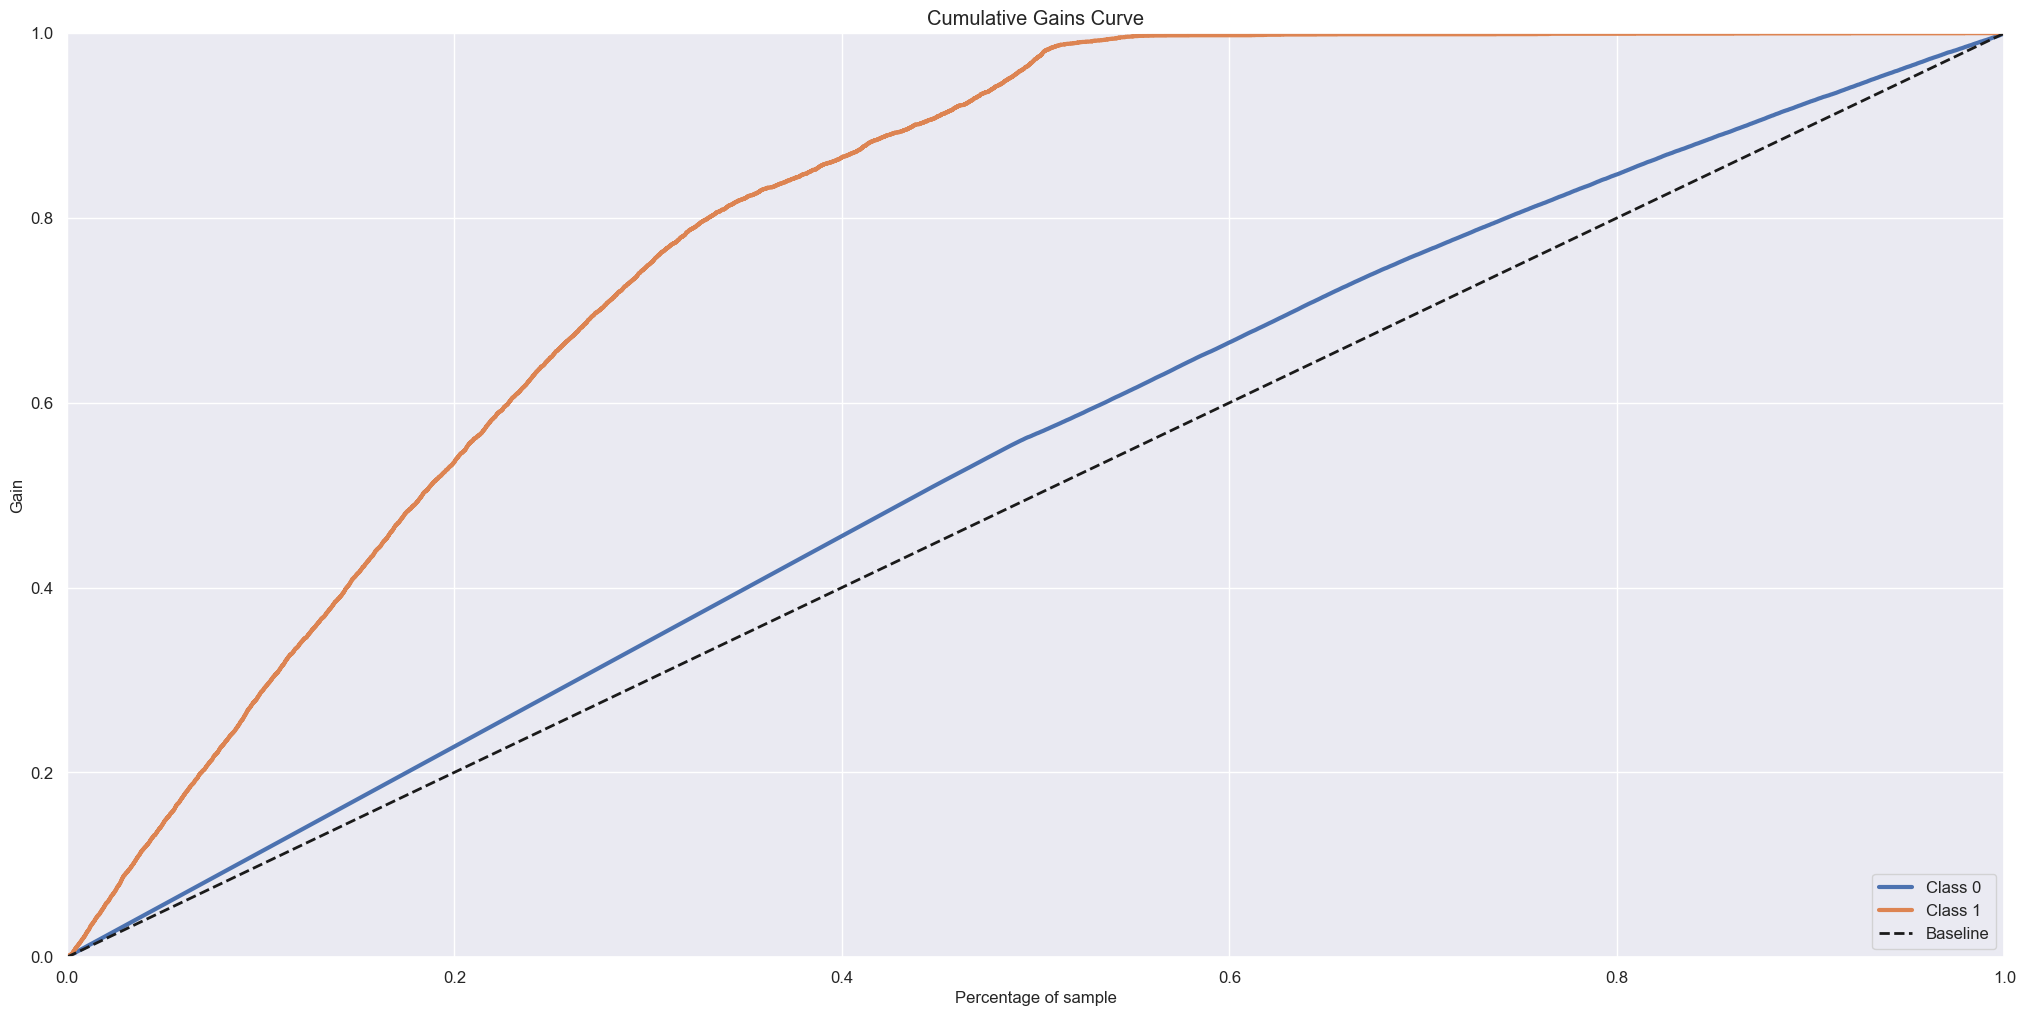

In [94]:
# Accumulative gain

plot_cumulative_gain(y_test, yhat_lr)

## 7.3 Random Forest Classifier

In [98]:
# model
rfc = RandomForestClassifier(max_depth=9, n_estimators=600, random_state=42)
rfc.fit(X_train_ml, y_train)

# prediction
yhat_rfc = rfc.predict( X_test_ml )
y_proba_rfc = rfc.predict_proba( X_test_ml )

### 7.3.1 Random Forest Classifier Score

In [117]:
rf_result_rank = ranking_performance('XGRandom ForestBoost', X_test_ml, y_test, y_proba_rfc, yhat_rfc,50)
rf_result_rank

,Model Name,Precision at K,Recall at K,Accuracy,F1_score
0,XGRandom ForestBoost,0.27451,0.001867,0.78407,0.427248


### 7.3.2 Random Forest Classifier Score - CV

In [118]:
rf_result_cv = cross_validation( 'Random Forest Classifier', rfc, X_train_ml, y_train, 5, verbose=False )
rf_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
Random Forest Classifier,1.0,0.0,0.883,0.889


### 7.3.3 Cumulative Gain Curve - RF

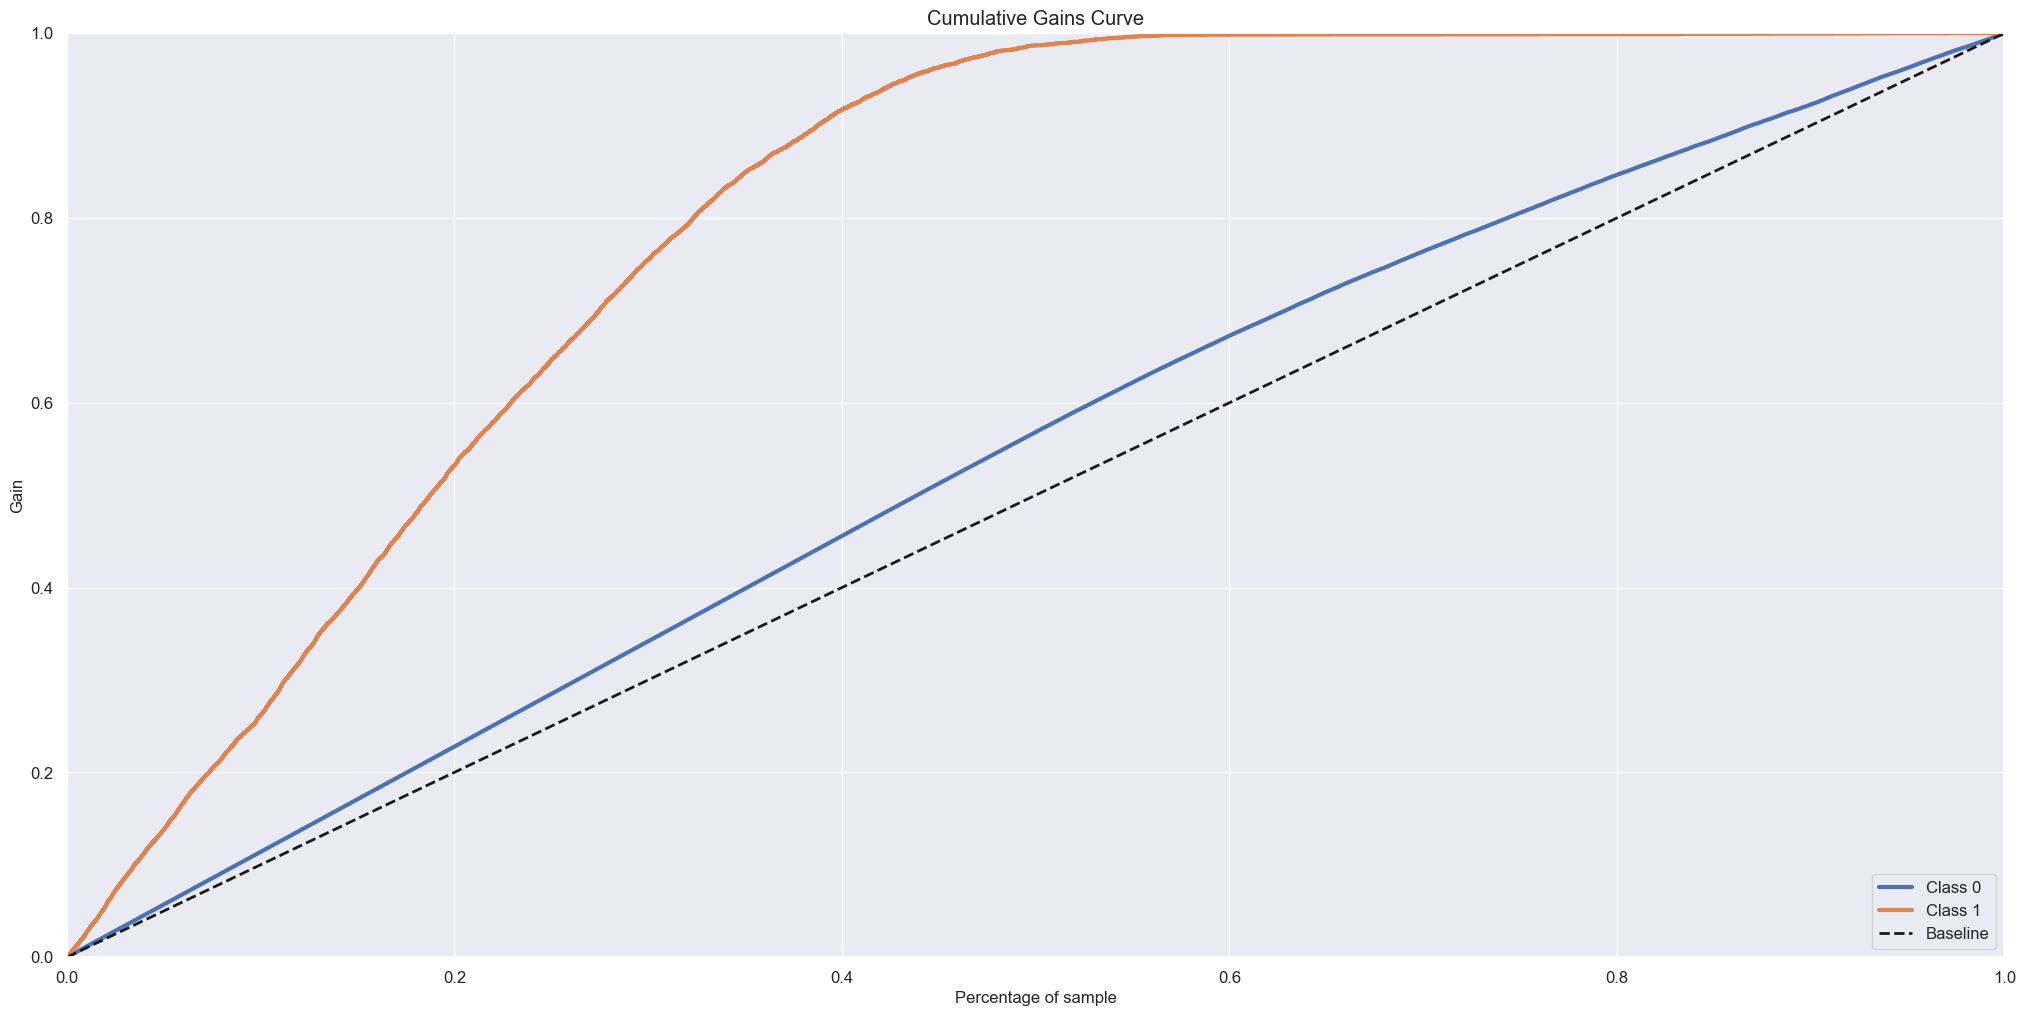

In [100]:
# Accumulative Gain
plot_cumulative_gain( y_test, y_proba_rfc )

## 7.4 Extra Trees Classifier

In [101]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# model training
et_model.fit( X_train_ml, y_train )

# model prediction
yhat_et = et_model.predict_proba( X_test_ml )
yhatp_et = et_model.predict( X_test_ml )

### 7.4.1 Extra Trees Classifier Score

In [119]:
et_result_rank = ranking_performance('Extra Trees Classifier', X_test_ml, y_test, yhat_et, yhatp_et,50)
et_result_rank

,Model Name,Precision at K,Recall at K,Accuracy,F1_score
0,Extra Trees Classifier,0.392157,0.002667,0.837728,0.328652


### 7.4.2 Extra Trees Classifier Score - CV

In [120]:
et_result_cv = cross_validation( 'Extra Trees Classifier', et_model, X_train_ml, y_train, 5, verbose=False )
et_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
Extra Trees Classifier,1.0,0.0,0.908,0.907


### 7.4.3 Cumulative Gain Curve - ET

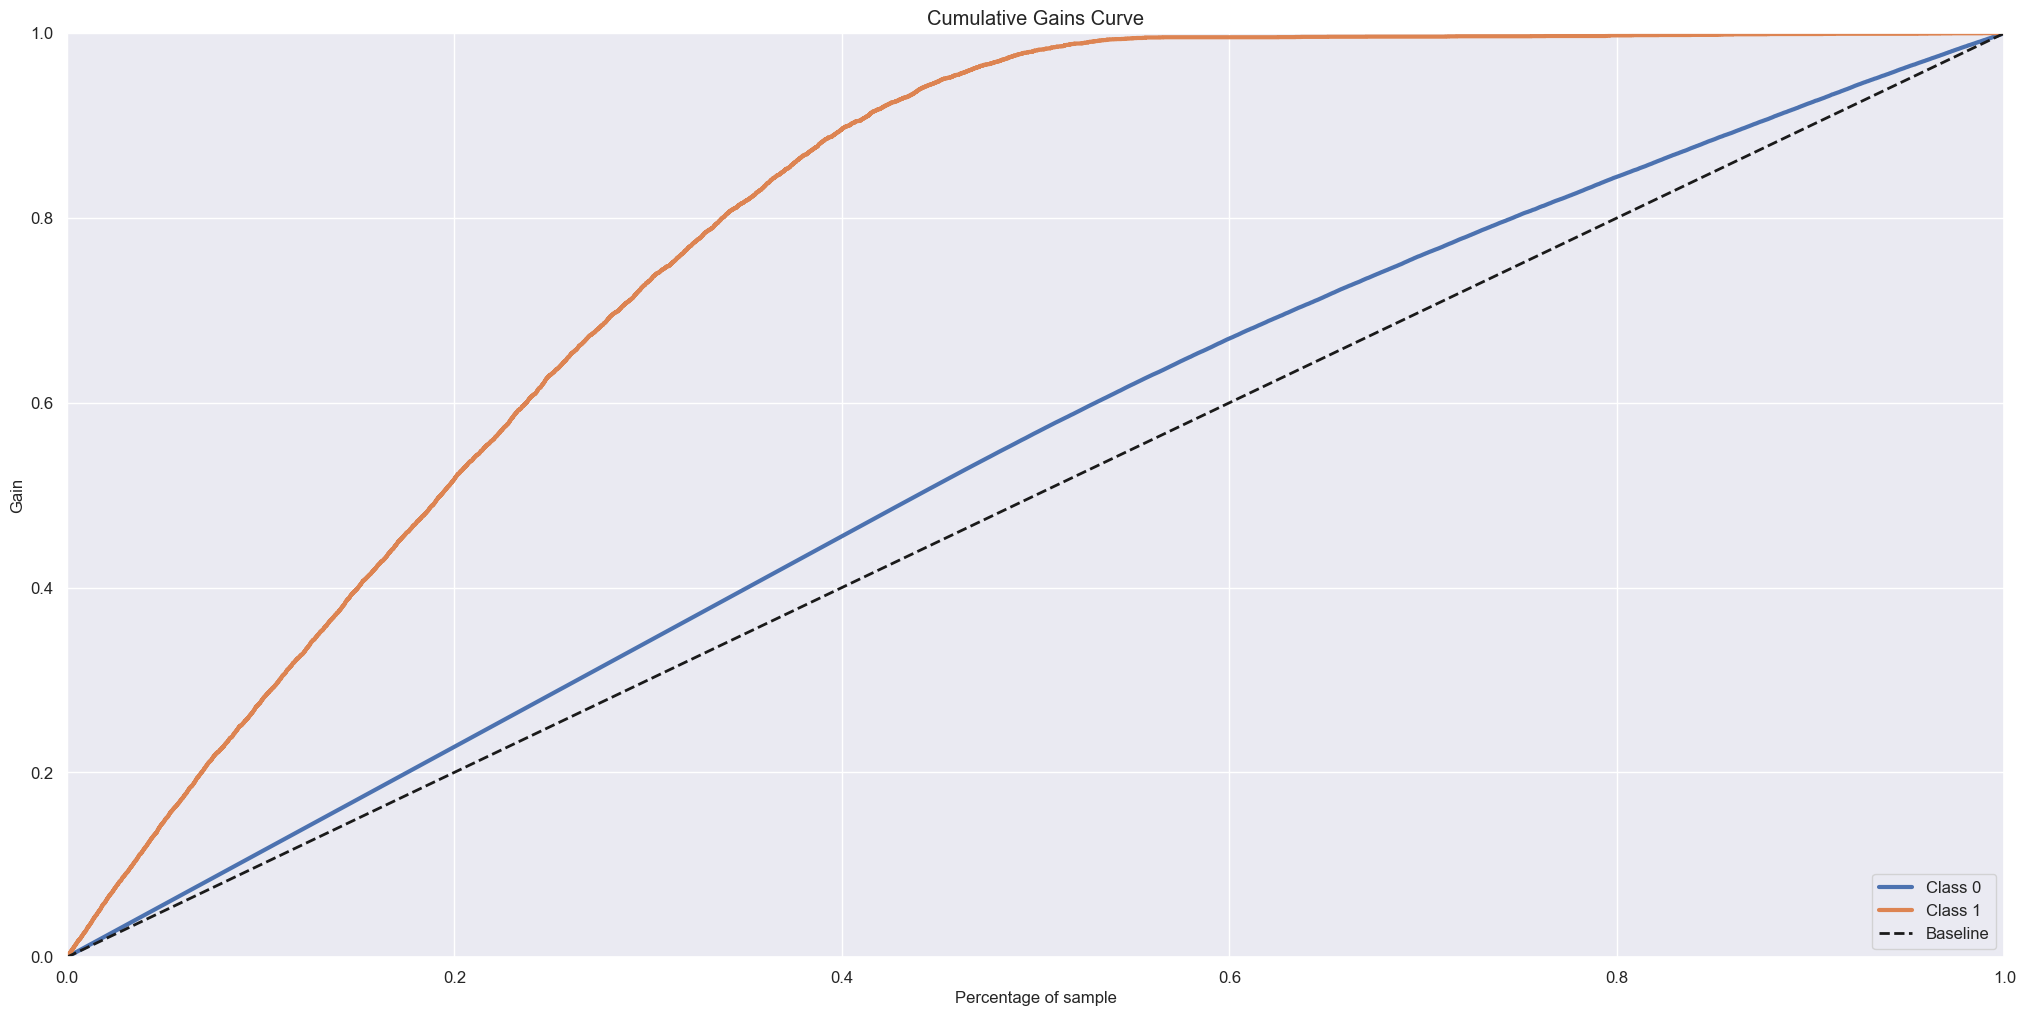

In [103]:
# Accumulative Gain
plot_cumulative_gain( y_test, yhat_et )

## 7.5 XGBoost Classifier

In [57]:
n = (y_train.shape[0] - y_train.sum())/y_train.sum()
# model definition
xgb_model = xgb.XGBClassifier(n_estimators = 600 ,scale_pos_weight=n, random_state=42 )

# model fit
xgb_model.fit(X_train_ml, y_train)

# model prediction
y_hat_xgb = xgb_model.predict(X_test_ml)
y_proba_xgb = xgb_model.predict_proba( X_test_ml )

### 7.5.1 XGBoost Classifier Score

In [54]:
xgb_result_rank = ranking_performance('XGBoost', X_test_ml, y_test, y_proba_xgb, y_hat_xgb, 50)
xgb_result_rank

,Model Name,Precision at K,Recall at K,Accuracy,F1_score
0,XGBoost,0.45098,0.003067,0.865673,0.236982


### 7.5.2 XGBoost Classifier Score - CV

In [122]:
xgb_result_cv = cross_validation( 'XGBoost Classifier', xgb_model, X_train_ml, y_train, 5, verbose=False )
xgb_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
XGBoost Classifier,1.0,0.0,0.92,0.915


### 7.5.3 Cumulative Gain Curve - XGB

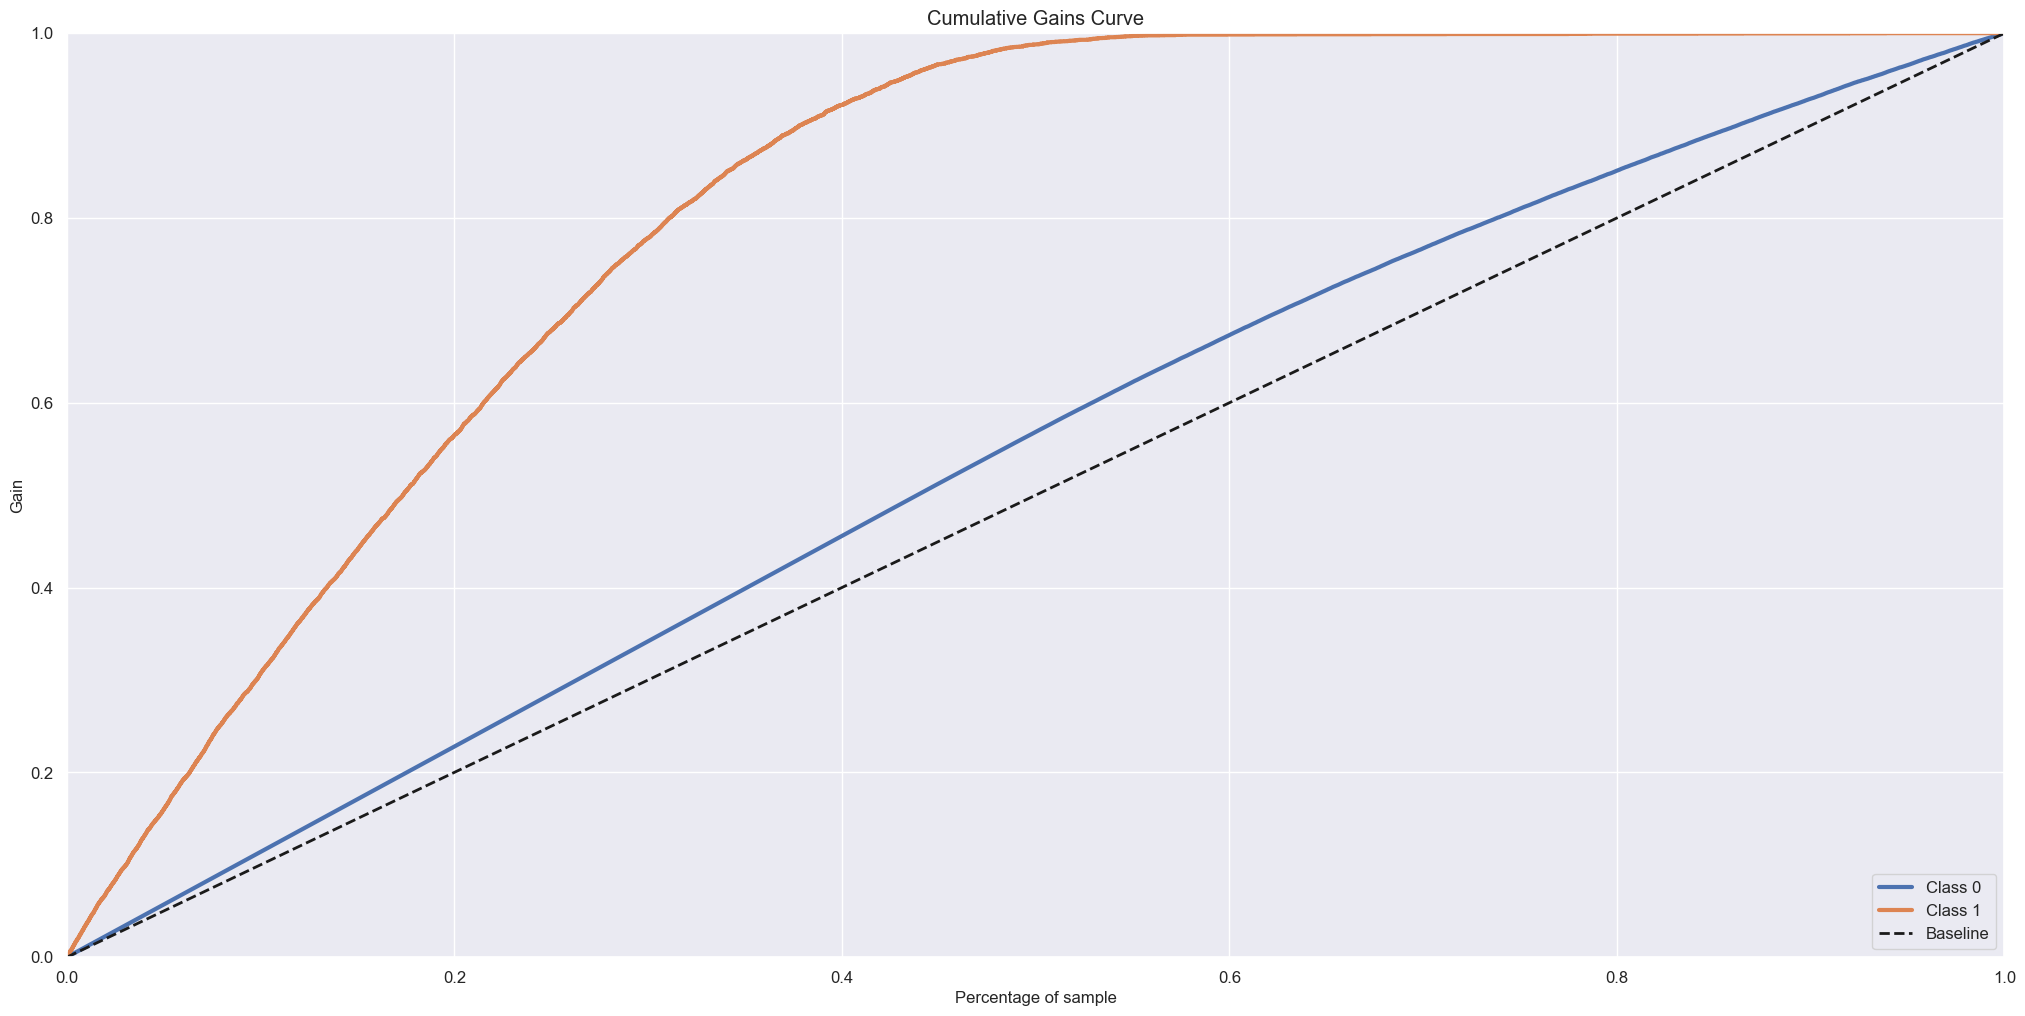

In [62]:
# Accumulative Gain
plot_cumulative_gain( y_test, y_proba_xgb )

## 7.5 Compare Model's Performance

### 7.5.1 Single Performance

In [123]:
# Comparing
modelling_result = pd.concat( [knn_result_rank, lr_result_rank, rf_result_rank, et_result_rank, xgb_result_rank] )
modelling_result.sort_values('Precision at K', ascending=False)

,Model Name,Precision at K,Recall at K,Accuracy,F1_score
0,XGBoost,0.450980,0.003067,0.865673,0.236982
0,K-Nearest Neighbors,0.411765,0.002800,0.770885,0.414582
0,Extra Trees Classifier,0.392157,0.002667,0.837728,0.328652
0,XGRandom ForestBoost,0.274510,0.001867,0.784070,0.427248
0,Logistic Regression,0.058824,0.000400,0.729148,0.427204


### 7.5.2 Real Performance - Cross Validation

In [127]:
modelling_result_cv = pd.concat( [lr_result_cv, rf_result_cv, et_result_cv, xgb_result_cv, knn_result_cv] )
modelling_result_cv.sort_values('F1_score - CV', ascending=False)

,Precision @k - CV,Recall @k - CV,Accuracy - CV,F1_score - CV
XGBoost Classifier,1.0,0.0,0.920,0.915
Extra Trees Classifier,1.0,0.0,0.908,0.907
Random Forest Classifier,1.0,0.0,0.883,0.889
K-Nearest Neighbors,1.0,0.0,0.855,0.861
Logistic Regression,0.7,0.0,0.843,0.857


## 7.6 Full Graphs Vizualization

### 7.6.1 Cumulative Gain Curve

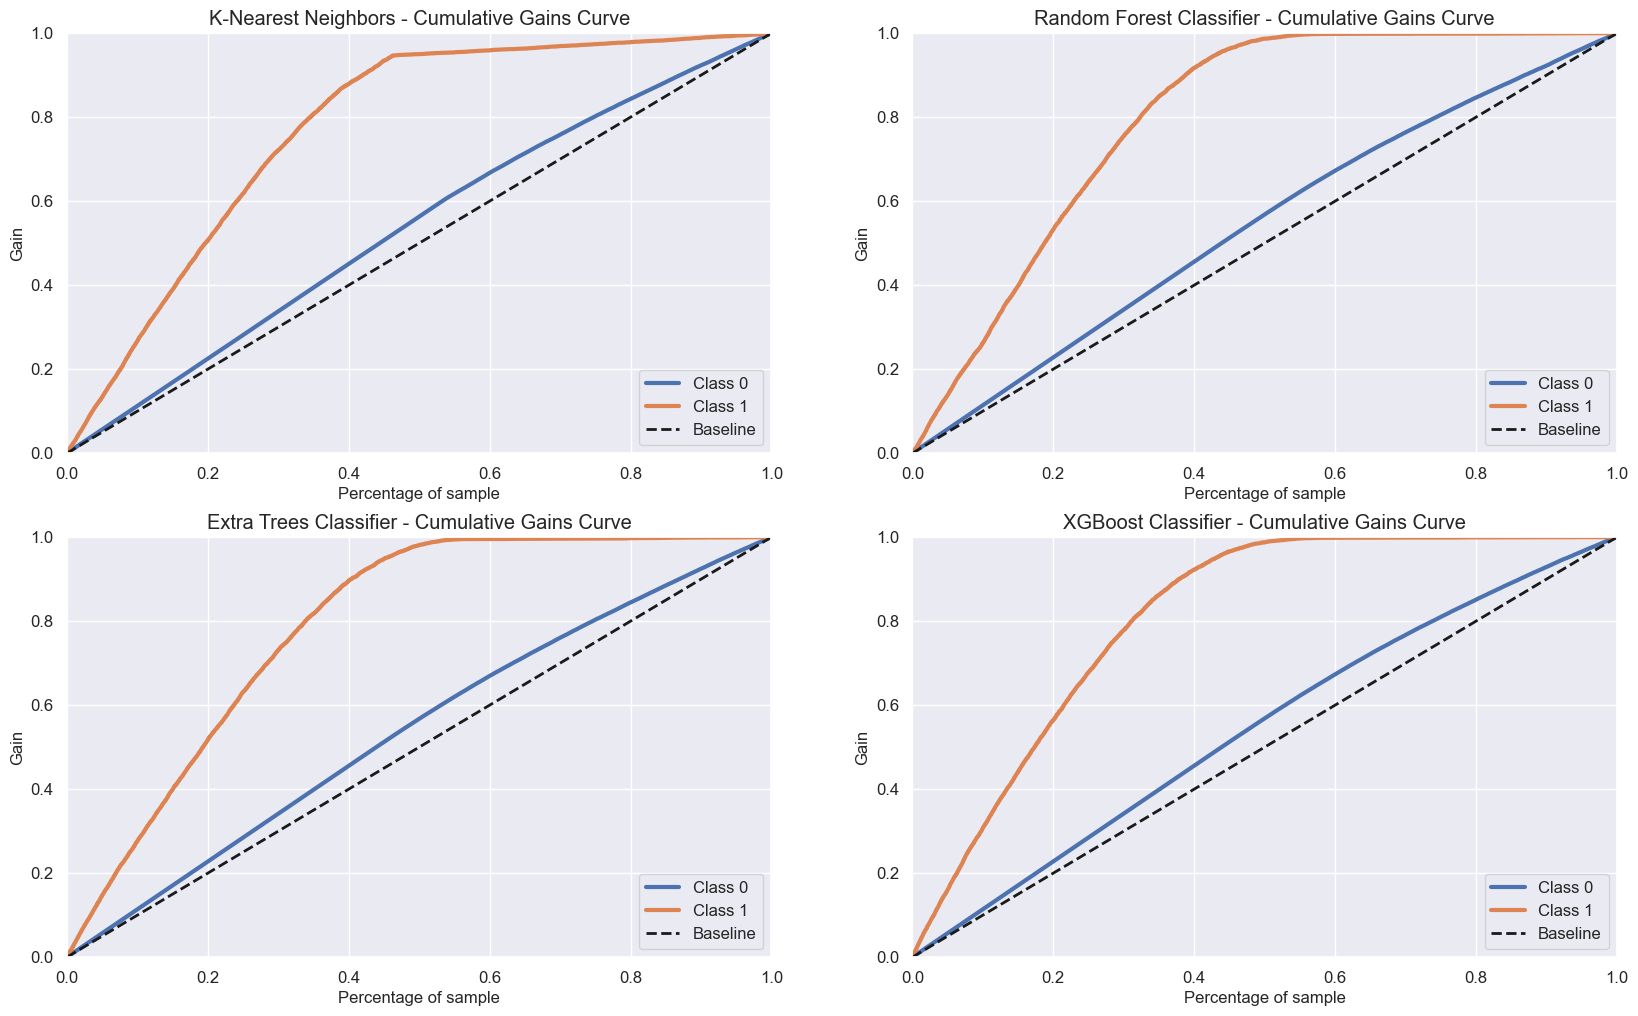

In [105]:
#Plot Cumulative Gain Curve

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

plot_cumulative_gain(y_test, yhat_knn, title='K-Nearest Neighbors - Cumulative Gains Curve', ax=ax1)

plot_cumulative_gain(y_test, y_proba_rfc, title='Random Forest Classifier - Cumulative Gains Curve', ax=ax2)

plot_cumulative_gain(y_test, yhat_et, title='Extra Trees Classifier - Cumulative Gains Curve', ax=ax3) 

plot_cumulative_gain(y_test, y_proba_xgb, title='XGBoost Classifier - Cumulative Gains Curve',ax=ax4)  

### 7.6.2 Plot Lift Curve

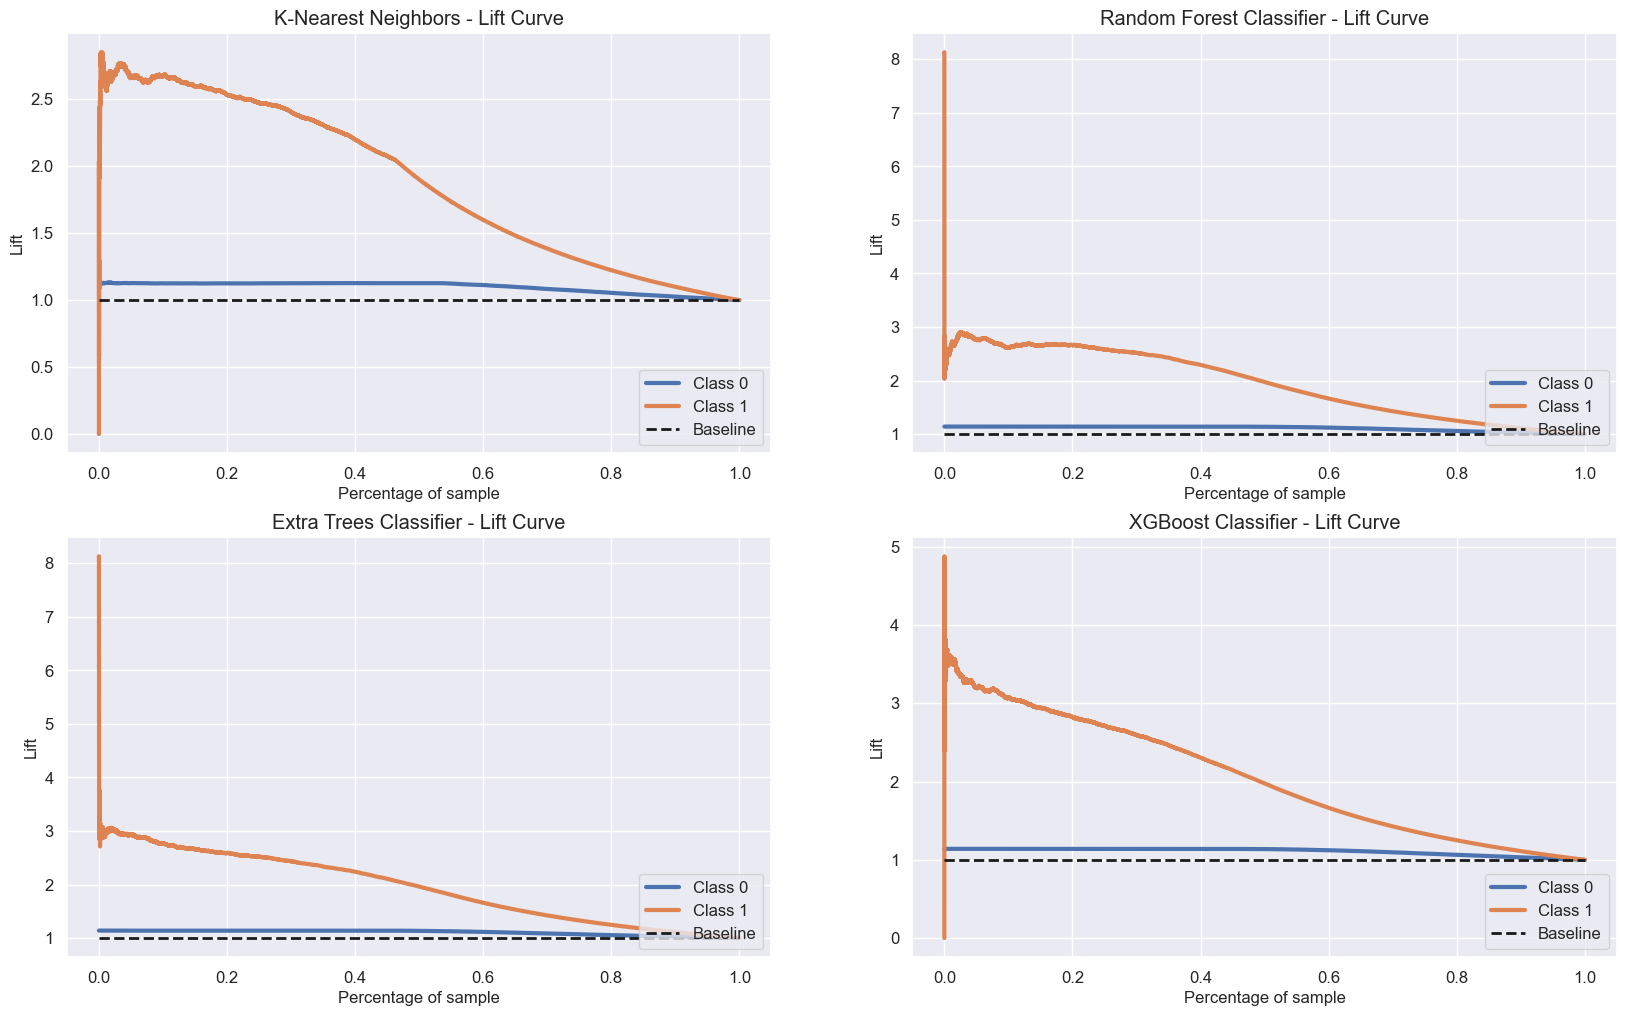

In [106]:
#Plot Lift Curve

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

plot_lift_curve(y_test, yhat_knn, title='K-Nearest Neighbors - Lift Curve', ax=ax1)

plot_lift_curve(y_test, y_proba_rfc, title='Random Forest Classifier - Lift Curve', ax=ax2)

plot_lift_curve(y_test, yhat_et, title='Extra Trees Classifier - Lift Curve', ax=ax3) 

plot_lift_curve(y_test, y_proba_xgb, title='XGBoost Classifier - Lift Curve',ax=ax4)  

# 8.0 Hyper Parameter Fine Tunning

In [50]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 200, 600)
    eta = trial.suggest_float('eta',0.01, 0.05)
    max_depth = trial.suggest_int('max_depth', 3, 9)
    subsample = trial.suggest_float('subsample',0.1, 0.9)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.1,0.9)
    
    # model definition
    xgb_model = xgb.XGBClassifier( n_estimators    = n_estimators, 
                                  eta              = eta, 
                                  max_depth        = max_depth, 
                                  subsample        = subsample,
                                  colsample_bytree = colsample_bytree
                                 )

    # model fit
    xgb_model.fit(X_train_ml, y_train)

    # ==== Model Prediction 
    # model prediction
    y_pred_xgb = xgb_model.predict(X_test_ml[cols_selected])

    return accuracy_score(y_test, y_pred_xgb)

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2023-10-09 14:13:51,267] A new study created in memory with name: no-name-4659984b-45e0-4cc0-8636-1d437c3d05c3
[I 2023-10-09 14:14:22,198] Trial 0 finished with value: 0.8628029781232576 and parameters: {'n_estimators': 300, 'eta': 0.028829598306915963, 'max_depth': 4, 'subsample': 0.5033222083404673, 'colsample_bytree': 0.6790259855516769}. Best is trial 0 with value: 0.8628029781232576.
[I 2023-10-09 14:15:46,537] Trial 1 finished with value: 0.8666568270523796 and parameters: {'n_estimators': 487, 'eta': 0.026814574033639134, 'max_depth': 8, 'subsample': 0.39400981686254766, 'colsample_bytree': 0.7246249612226158}. Best is trial 0 with value: 0.8628029781232576.
[I 2023-10-09 14:16:08,949] Trial 2 finished with value: 0.8556364590508052 and parameters: {'n_estimators': 406, 'eta': 0.01746343458874925, 'max_depth': 3, 'subsample': 0.3417418157065363, 'colsample_bytree': 0.313290679820969}. Best is trial 2 with value: 0.8556364590508052.
[I 2023-10-09 14:17:04,859] Trial 3 finished

{'n_estimators': 205,
 'eta': 0.049752879277907364,
 'max_depth': 3,
 'subsample': 0.7230844783667326,
 'colsample_bytree': 0.20983802094295673}

## 8.1 Final Model

In [52]:
params = {'n_estimators': 205,
 'eta': 0.049752879277907364,
 'max_depth': 3,
 'subsample': 0.7230844783667326,
 'colsample_bytree': 0.20983802094295673}

### 8.1.1 Train XGBoost Classifier Model

In [55]:
# model definition
xgb_model_tunned = xgb.XGBClassifier(n_estimators      = params['n_estimators'],
                                    eta               = params['eta'],
                                    max_depth         = params['max_depth'],
                                    subsample         = params['subsample'],
                                    colsample_bytree  = params['colsample_bytree'],
                                    n_jobs=-1)

# model fit
xgb_model_tunned.fit(X_train_ml, y_train)

# model prediction
y_hat_xgb_tunned = xgb_model_tunned.predict( X_test_ml )
y_proba_xgb_tunned = xgb_model_tunned.predict_proba( X_test_ml )

xgb_result_rank_tunned = ranking_performance('XGBoost', X_test_ml, y_test, y_proba_xgb_tunned, y_hat_xgb_tunned, 50)
xgb_result_rank_tunned

,Model Name,Precision at K,Recall at K,Accuracy,F1_score
0,XGBoost,0.352941,0.0024,0.828856,0.381534


### 8.1.2 Plot Cumulative Gain

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

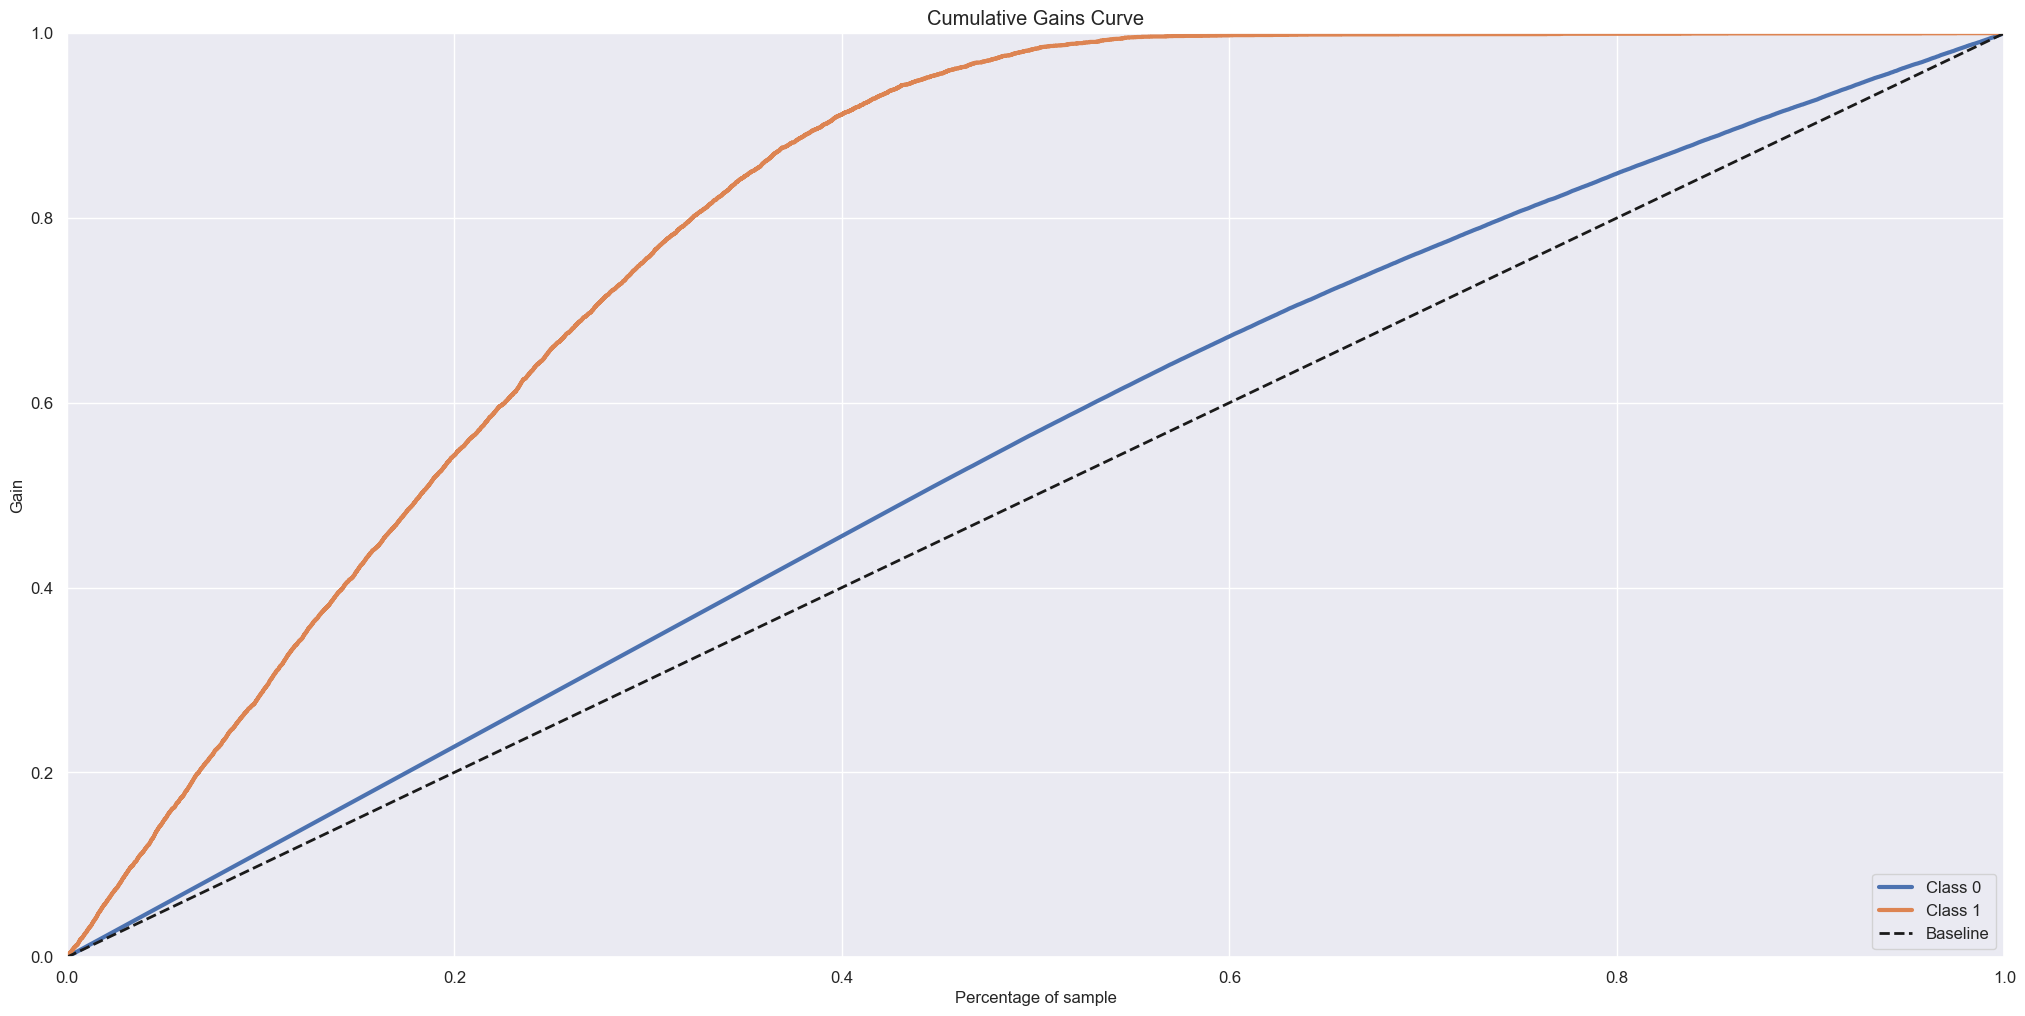

In [56]:
# Accumulative Gain
plot_cumulative_gain( y_test, y_proba_xgb_tunned )

# 9.0 Bussiness Performance

In [81]:
df_aux = X_test.copy()

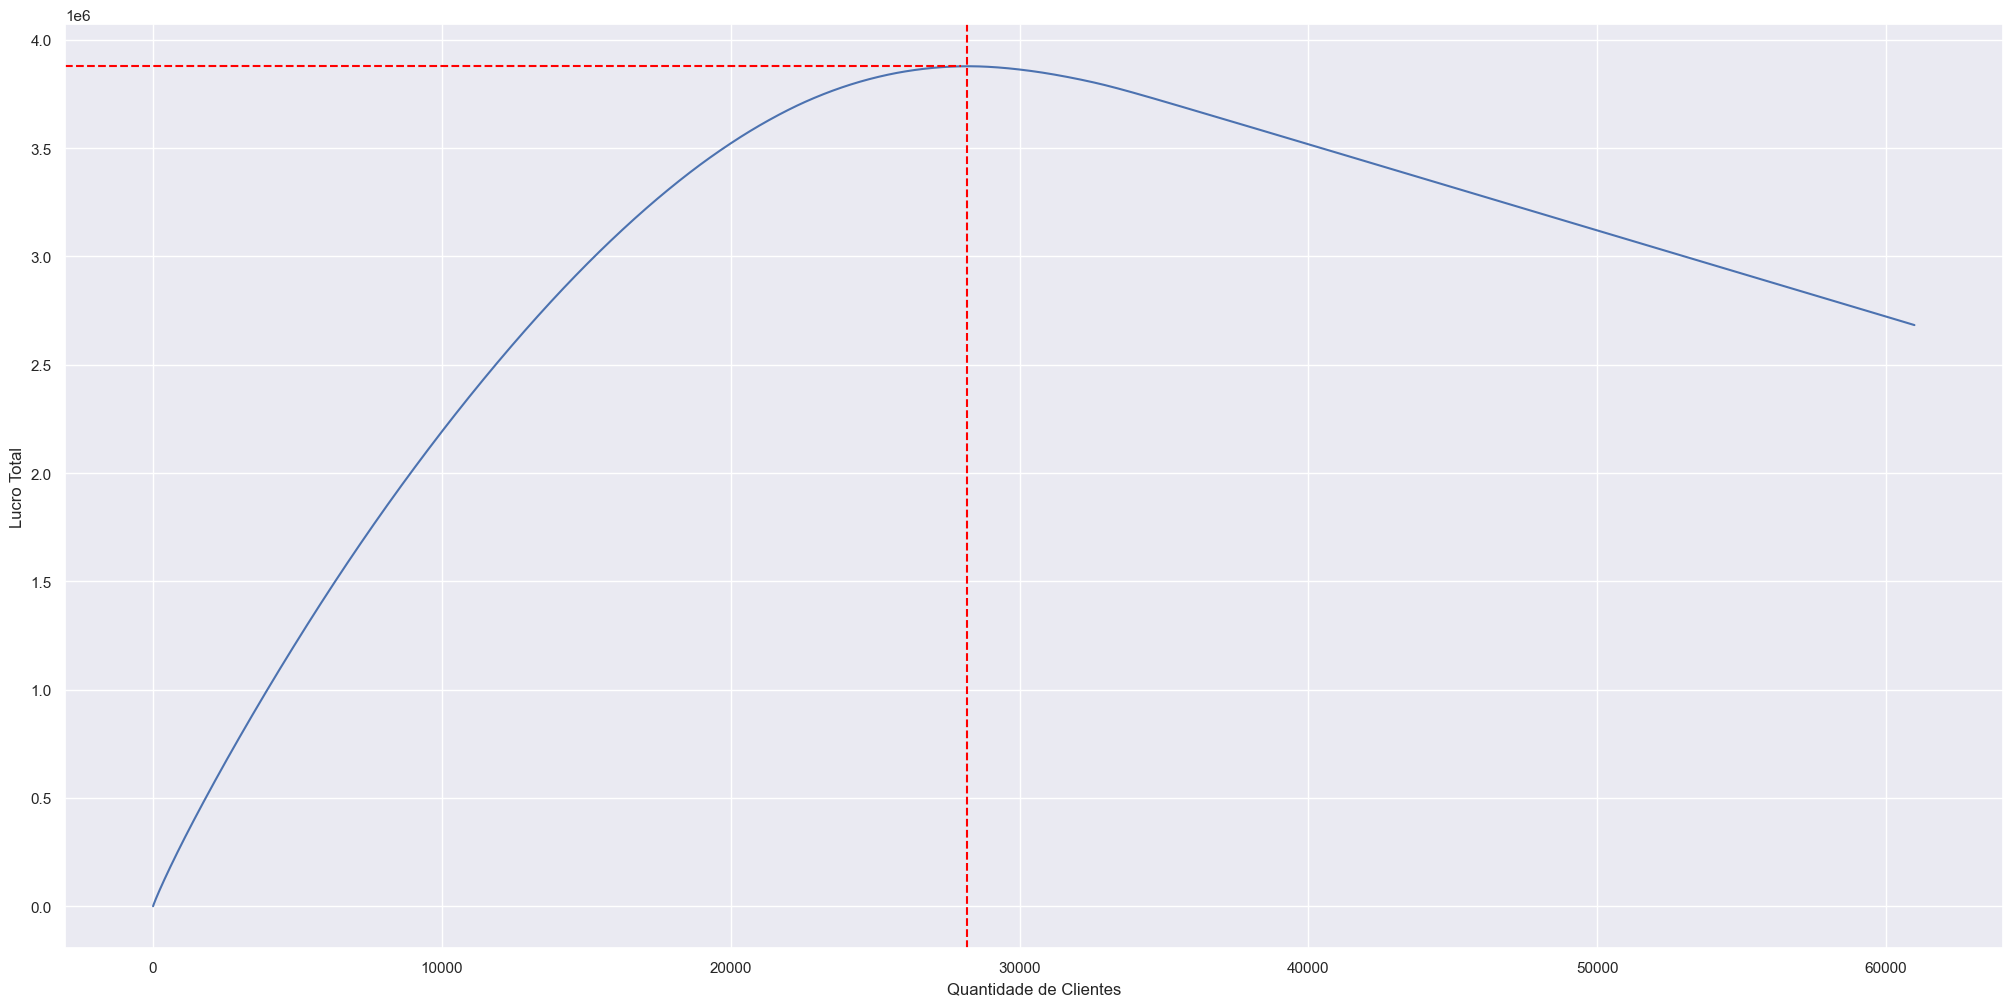

In [86]:
df_aux['id'] = X_test['id'].copy()
df_aux['score'] = y_proba_xgb[:,1]
df_aux = df_aux.sort_values(by='score', ascending=False)

estimated_insurance = 540.00
cost_per_call = 40.00

df_aux['estimated_profit'] = df_aux['score']* estimated_insurance - cost_per_call
df_aux['cumulative_profit'] = df_aux['estimated_profit'].cumsum()

posicoes = np.arange(len(df_aux)) + 1
plt.plot(posicoes, df_aux['cumulative_profit'])

plt.xlabel('Quantidade de Clientes')
plt.ylabel('Lucro Total')

indice_maximo = np.argmax(df_aux['cumulative_profit'])
x_maximo = posicoes[indice_maximo]
y_maximo = df_aux['cumulative_profit'].iloc[indice_maximo]

# Adicionar linha vertical até o eixo x
plt.axvline(x=x_maximo, ymin=0, ymax=y_maximo / np.max(df_aux['cumulative_profit']), color='red', linestyle='--')

# Adicionar linha horizontal até o eixo y
plt.axhline(y=y_maximo, xmin=0, xmax=x_maximo / np.max(posicoes), color='red', linestyle='--')

In [93]:
print(f'Quantidade em percentual ideal da base de clientes para realizar as chamadas: {100 * round(x_maximo / df_aux.shape[0], 2):.2f}%')
print(f'Lucro Total ligando para 100% Clientes: R$ {round(df_aux["cumulative_profit"].iloc[60977]):.2f}')
print(f'Lucro Total ligando para 46% Clientes: R$ {round(y_maximo):.2f}')

Quantidade Ideal da base de clientes para ligar: 46.00%
Lucro Total ligando para 100% Clientes: R$2683235.00
Lucro Total ligando para 46% Clientes: R$3878010.00


# 10.0 Deploy to Production

In [58]:
# Save Trained Model
pickle.dump( xgb_model, open( '/Users/luishmq/Documents/repos/insurance_cross_sell/src/models/xgb_model.pkl', 'wb' ) )

In [59]:
class HealthInsurance():
    def __init__(self):
        self.home_path='/Users/luishmq/Documents/repos/insurance_cross_sell/'
        self.annual_premium_scaler       = pickle.load(open(self.path + 'src/features/annual_premium.pkl'))
        self.age_scaler                  = pickle.load(open(self.path + 'src/features/age.pkl'))
        self.days_scaler                 = pickle.load(open(self.path + 'src/features/days_client_associate.pkl'))
        self.gender_scaler               = pickle.load(open(self.path + 'src/features/gender.pkl'))
        self.region_code_scaler          = pickle.load(open(self.path + 'src/features/region_code.pkl'))
        self.sales_channel_scaler        = pickle.load(open(self.path + 'src/features/sales_channel.pkl'))             

    def feature_engineering(self, df2):

        # vericle_age
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                             'between_1_2_year' if x == '1-2 Year' else 
                                                             'over_2_years')

        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        return df2
    
    
    def data_preparation(self, df5):
        
        ## annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        ## age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        ## days_client_associate
        df5['days_client_associate'] = self.days_scaler.transform( df5[['days_client_associate']].values )

        ## vehicle_age
        df5 = pd.get_dummies(df5, prefix='vehicle_age',columns=['vehicle_age'])

        # gender 
        df5.loc[:,'gender'] = df5['gender'].map(self.gender_scaler)

        # region_code 
        df5.loc[:,'region_code'] = df5['region_code'].map(self.region_code_scaler)

        # vehicle damage
        df5.loc[:,'vehicle_damage'] = df5['vehicle_damage'].map(self.vehicle_damage_scaler)

        ## sales_channel 
        df5.loc[:,'sales_channel'] = df5['sales_channel'].map(self.sales_channel_scaler)

        cols_selected = [
                'days_client_associate',
                'annual_premium',
                'gender',
                'age',
                'region_code',
                'vehicle_damage',
                'sales_channel',
                'vehicle_age_bellow_1_year',
                'vehicle_insured']

        
        return df5[cols_selected]

    def get_predict(self, model, original_data, test_data):
        
        # model prediction
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [60]:
from flask             import Flask, request, Response
from healthinsurance   import HealthInsurance
from urllib.parse import quote as url_quote

# loading model
model = pickle.load( open( '/Users/luishmq/Documents/repos/insurance_cross_sell/src/models/xgb_model.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def insurance_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        pipeline = HealthInsurance()
        
        # feature engineering
        df2 = pipeline.feature_engineering( test_raw )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'healthinsurance'

## 10.3 API Tester

In [61]:
df10 = df_raw.drop('interested', axis=1)

In [62]:
df10.to_csv('test.csv')

In [66]:
test = pd.read_csv('test.csv')
test = test.sample(20)

test.columns = [col.lower() for col in test.columns]
data = json.dumps(test.to_dict(orient='records'))

url = 'https://test-web-api-crsell.onrender.com/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url,data=data,headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 500


In [ ]:
pd.DataFrame(r.json(),columns= r.json()[0].keys())